# Code for AggCVAE model for individual administrative levels

This notebook provides code to construct and run the AggCVAE model on administrative levels 1 and 2 separately. This notebook builds on the notebook written by ES: https://github.com/MLGlobalHealth/aggVAE, and code developed by DJ. In particular, the notebook uses the deep learning $\verb|JAX|$ developed by Google (https://github.com/google/jax) and the probabilistic programming library $\verb|numpyro|$ (https://num.pyro.ai/en/latest/index.html#introductory-tutorials).

## Importing Libraries 

In [2]:
# general libraries
import time
import math
import numpy as np
from shapely import geometry
from shapely.geometry import Polygon, Point
import matplotlib
import matplotlib.pyplot as plt
import pickle
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
# import dill
import geopandas
import geopandas as gpd
import matplotlib.colors as colors
import wandb
from typing import Optional, Union
from pathlib import Path
import orbax.checkpoint
import dill
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error, mean_absolute_error


# JAX
import jax
import jax.numpy as jnp

jax.config.update('jax_platform_name', 'gpu')  # Use GPU

from jax import random, lax, jit, ops
from jax.example_libraries import stax
# previously was "from jax.experimental import stax" due to previous versions of jax


# Numpyro
import numpyro
from numpyro.infer import SVI, MCMC, NUTS, init_to_median, Predictive, RenyiELBO
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro import optim
import random as rnd

# check versions
print(numpyro.__version__)
print(jax.__version__)
# print(torch.__version__)
from platform import python_version
print(python_version())

0.14.0
0.4.30
3.12.3


## Admin type

In [6]:
# Set admin level
admin_level = 2

## Read shape files

This section reads the shape files of the boundaries of the administrative level.

In [7]:
# read shape files
shape_new = gpd.read_file(f"data/Shapefiles/zmb_admbnda_adm{admin_level}_dmmu_20201124.shp")
shape_new = shape_new[[f"ADM{admin_level}_EN", 'geometry']]
shape_new['new'] = 1
shape_new

ADM2_EN                                           geometry  new
0         Chibombo  POLYGON ((28.00409 -14.51361, 28.00989 -14.514...    1
1         Chisamba  POLYGON ((28.65022 -14.38920, 28.65131 -14.389...    1
2         Chitambo  POLYGON ((29.99949 -12.00267, 30.00002 -12.002...    1
3     Itezhi-tezhi  POLYGON ((26.99044 -15.46178, 27.20284 -15.468...    1
4            Kabwe  POLYGON ((28.33593 -14.26089, 28.33684 -14.262...    1
..             ...                                                ...  ...
110          Sioma  POLYGON ((23.22303 -16.24968, 23.22304 -16.249...    1
111  Kapiri Mposhi  POLYGON ((28.97528 -13.77728, 28.97804 -13.777...    1
112      Nchelenge  POLYGON ((28.98384 -9.11358, 29.01004 -9.12788...    1
113   Shiwamg'andu  POLYGON ((31.71596 -10.50328, 31.72146 -10.507...    1
114      Mporokoso  POLYGON ((29.88054 -9.21468, 29.88514 -9.21548...    1

[115 rows x 3 columns]

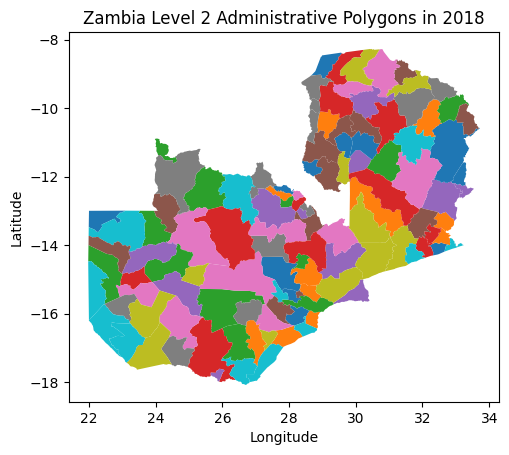

In [8]:
# Plot boundaries
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
shape_new.plot(ax=ax, column=f"ADM{admin_level}_EN")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Zambia Level {admin_level} Administrative Polygons in 2018')
plt.savefig(f'figures/ZMB2018_adm{admin_level}_polygons.pdf')

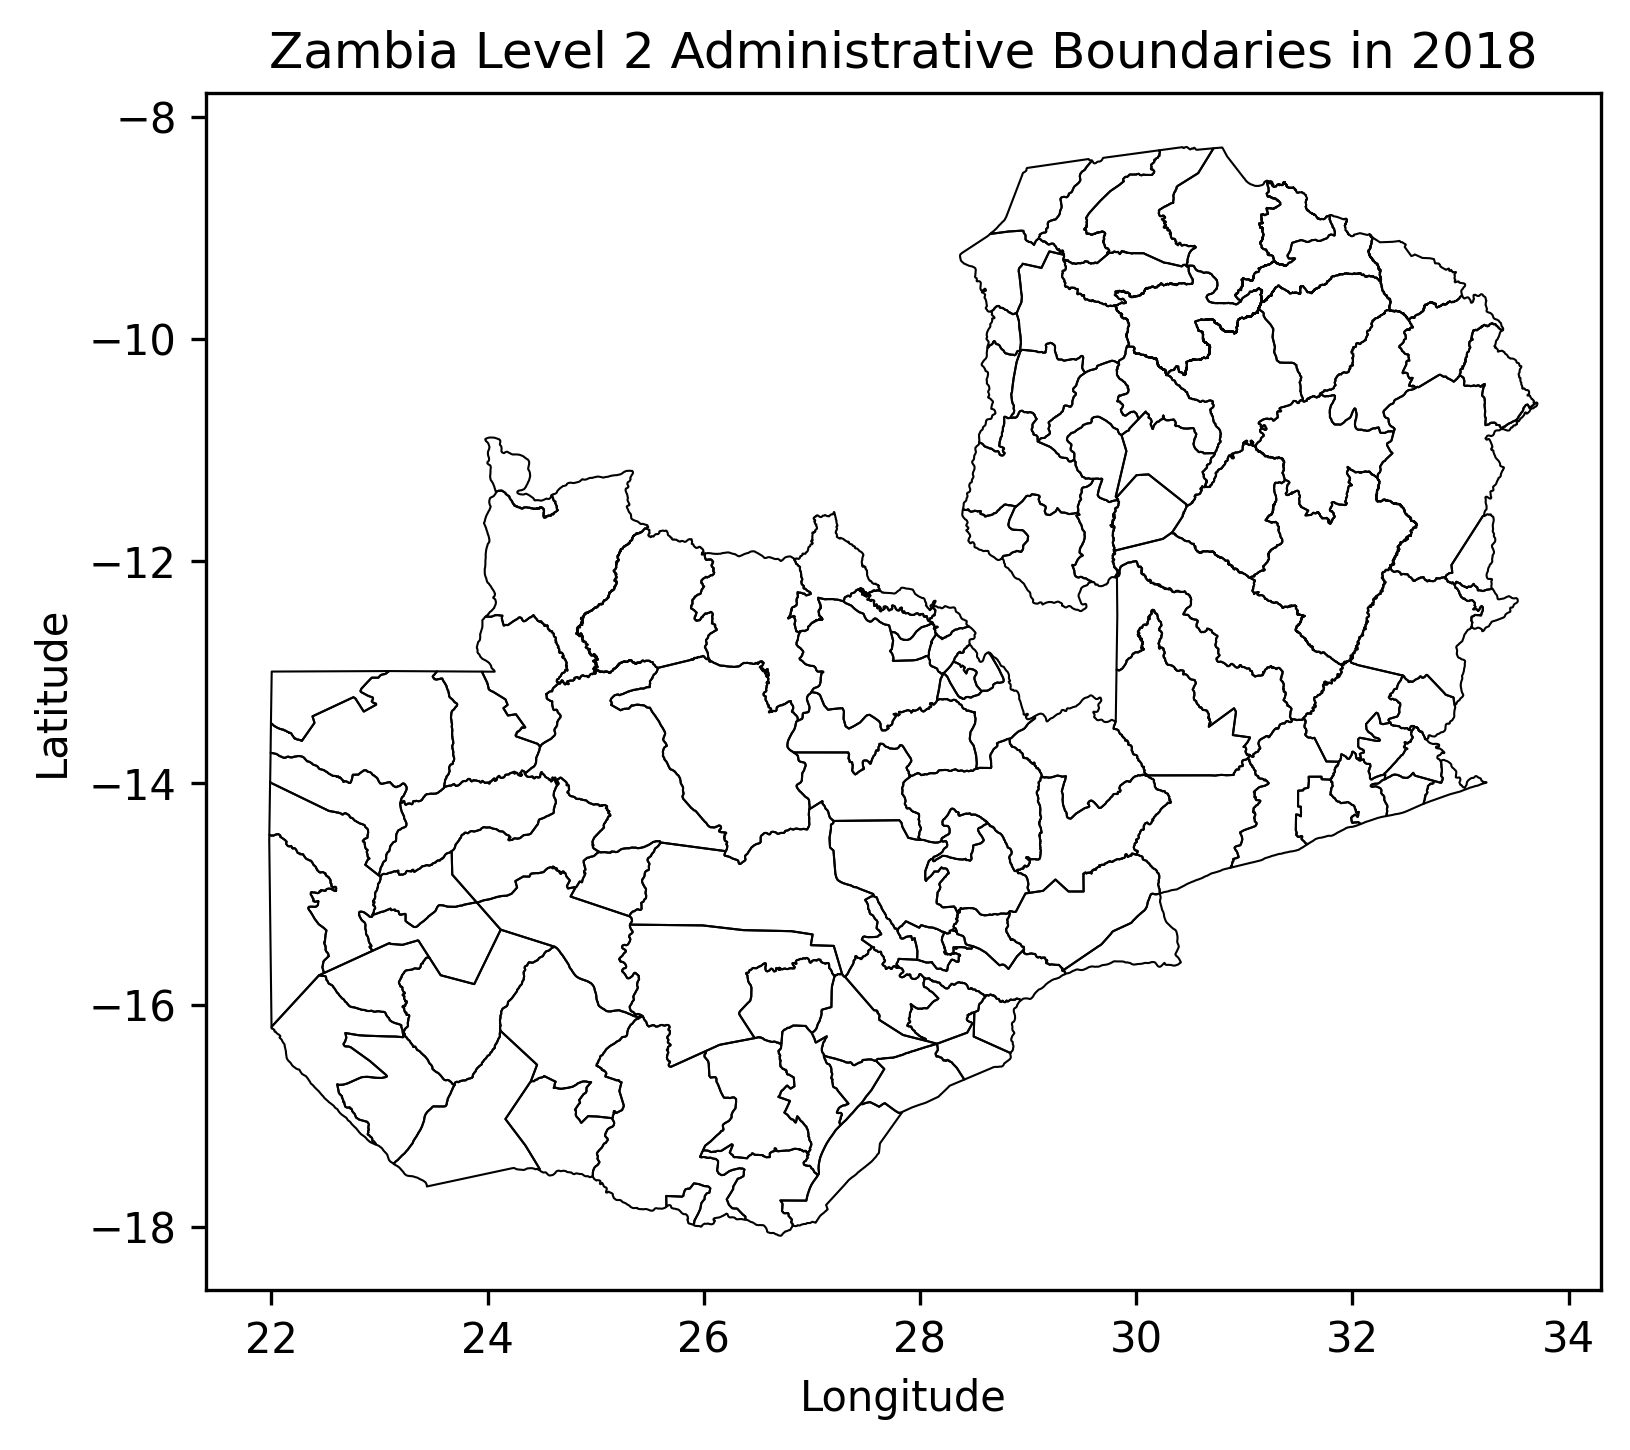

In [9]:
# Plot boundaries
shape_new.boundary.plot(linewidth=0.5,  edgecolor='black', figsize=(6,6))
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Zambia Level {admin_level} Administrative Boundaries in 2018')
plt.savefig(f'figures/ZMB2018_adm{admin_level}_boundaries.pdf')

In [10]:
# Capitalise unit names
names_shape_new = shape_new[f"ADM{admin_level}_EN"].values
shape_new[f"ADM{admin_level}_EN"] =  np.array([names_shape_new[i].upper() for i in range(len(names_shape_new))])
shape_new.head(5)

ADM2_EN                                           geometry  new
0      CHIBOMBO  POLYGON ((28.00409 -14.51361, 28.00989 -14.514...    1
1      CHISAMBA  POLYGON ((28.65022 -14.38920, 28.65131 -14.389...    1
2      CHITAMBO  POLYGON ((29.99949 -12.00267, 30.00002 -12.002...    1
3  ITEZHI-TEZHI  POLYGON ((26.99044 -15.46178, 27.20284 -15.468...    1
4         KABWE  POLYGON ((28.33593 -14.26089, 28.33684 -14.262...    1

In [ ]:
# check
names_shape_new = shape_new[f"ADM{admin_level}_EN"].values
names_shape_new

array(['CHIBOMBO', 'CHISAMBA', 'CHITAMBO', 'ITEZHI-TEZHI', 'KABWE',
       'LUANO', 'MKUSHI', 'MUMBWA', 'NGABWE', 'SERENJE', 'CHILILABOMBWE',
       'CHINGOLA', 'KALULUSHI', 'KITWE', 'LUANSHYA', 'LUFWANYAMA',
       'MASAITI', 'MPONGWE', 'MUFULIRA', 'NDOLA', 'CHADIZA', 'CHASEFU',
       'CHIPANGALI', 'CHIPATA', 'KASENENGWA', 'KATETE', 'LUMEZI',
       'LUNDAZI', 'MAMBWE', 'NYIMBA', 'PETAUKE', 'SINDA', 'VUBWI',
       'CHEMBE', 'CHIENGI', 'CHIFUNABULI', 'CHIPILI', 'KAWAMBWA', 'LUNGA',
       'MANSA', 'MILENGI', 'MWANSABOMBWE', 'MWENSE', 'SAMFYA', 'CHILANGA',
       'CHIRUNDU', 'CHONGWE', 'KAFUE', 'LUANGWA', 'LUSAKA', 'RUFUNSA',
       'SHIBUYUNJI', 'CHAMA', 'CHINSALI', 'ISOKA', 'KANCHIBIYA',
       'LAVUSHIMANDA', 'MAFINGA', 'MPIKA', 'NAKONDE', 'CHAVUMA',
       'IKELENGE', 'KABOMPO', 'KALUMBILA', 'KASEMPA', 'MANYINGA',
       'MUFUMBWE', 'MUSHINDANO', 'MWINILUNGA', 'SOLWEZI', 'ZAMBEZI',
       'CHILUBI', 'KAPUTA', 'KASAMA', 'LUNTE DISTRICT', 'LUPOSOSHI',
       'LUWINGU', 'MBALA', 'MPU

# HIV Prevalence data

This section reads the HIV prevalence data obtained from DHS. 

In [12]:
# read HIV prevalence data from DHS (not publicly available).
infections_new = pd.read_csv(f"../../data/dhs/ZMB_prev_data_admin{admin_level}.csv")
infections_new = infections_new[['unit', 'usage', 'num_rdt', 'num_rdt_positive', 'prev_estimate']]
infections_new = infections_new.rename({'unit': 'area'}, axis='columns')
infections_new = infections_new.sort_values(by=['area'])
infections_new.head(5)

area     usage     num_rdt  num_rdt_positive  prev_estimate
0  Chadiza  0.592593   43.522101          2.352546       0.054054
1    Chama  0.656690  219.745559         13.109616       0.059658
2  Chasefu  0.491268  157.033307          2.872475       0.018292
3  Chavuma  0.438596   56.444920          5.039725       0.089286
4   Chembe  0.826087   50.954995          0.000000       0.000000

## Merge infections and shape

This section merges the boundaries of the administrative levels with the corresponding HIV observed prevalence from DHS.

In [13]:
# Add administrative units with no DHS survey clusters.
if (admin_level==2):
    # Create new rows with zero values
    new_rows = pd.DataFrame({'area': ['CHIRUNDU', 'ITEZHI-TEZHI', 'SHIBUYUNJI'],
                             'usage': [0.0, 0.0, 0.0],
                             'num_rdt': [0.0, 0.0, 0.0],
                             'num_rdt_positive': [0.0, 0.0, 0.0],
                             'prev_estimate': [0.0, 0.0, 0.0]})

    # Append new rows to infections_new
    infections_new = pd.concat([infections_new, new_rows])

In [14]:
# Check names
names_infections_new = infections_new.area.values
shape_new = shape_new.rename({f"ADM{admin_level}_EN": 'area'}, axis='columns')
shape_new = shape_new.sort_values(by=['area'])
shape_new.head(3)
names_shape_new = shape_new['area'].values
print(names_infections_new)
print(names_shape_new)

['Chadiza' 'Chama' 'Chasefu' 'Chavuma' 'Chembe' 'Chibombo' 'Chiengi'
 'Chifunabuli' 'Chikankanta' 'Chilanga' 'Chililabombwe' 'Chilubi'
 'Chingola' 'Chinsali' 'Chipangali' 'Chipata' 'Chipili' 'Chisamba'
 'Chitambo' 'Choma' 'Chongwe' 'Gwembe' 'Ikelenge' 'Isoka' 'Kabompo'
 'Kabwe' 'Kafue' 'Kalabo' 'Kalomo' 'Kalulushi' 'Kalumbila' 'Kanchibiya'
 'Kaoma' 'Kapiri Mposhi' 'Kaputa' 'Kasama' 'Kasempa' 'Kasenengwa' 'Katete'
 'Kawambwa' 'Kazungula' 'Kitwe' 'Lavushimanda' 'Limulunga' 'Livingstone'
 'Luampa' 'Luangwa' 'Luano' 'Luanshya' 'Lufwanyama' 'Lukulu' 'Lumezi'
 'Lundazi' 'Lunga' 'Lunte District' 'Lupososhi' 'Lusaka' 'Luwingu'
 'Mafinga' 'Mambwe' 'Mansa' 'Manyinga' 'Masaiti' 'Mazabuka' 'Mbala'
 'Milengi' 'Mitete' 'Mkushi' 'Mongu' 'Monze' 'Mpika' 'Mpongwe' 'Mporokoso'
 'Mpulungu' 'Mufulira' 'Mufumbwe' 'Mulobezi' 'Mumbwa' 'Mungwi'
 'Mushindano' 'Mwandi' 'Mwansabombwe' 'Mwense' 'Mwinilunga' 'Nakonde'
 'Nalolo' 'Namwala' 'Nchelenge' 'Ndola' 'Ngabwe' 'Nkeyema' 'Nsama'
 'Nyimba' 'Pemba' 'Petauke' 'R

In [15]:
# Re-labelling names for admin level 1
if (admin_level==1):
    names_infections_new[6] = 'North-Western'
# Convert to uppercase
names_infections_new = [names_infections_new[i].upper() for i in range(len(names_infections_new))]
print(names_infections_new)
print(names_shape_new)

['CHADIZA', 'CHAMA', 'CHASEFU', 'CHAVUMA', 'CHEMBE', 'CHIBOMBO', 'CHIENGI', 'CHIFUNABULI', 'CHIKANKANTA', 'CHILANGA', 'CHILILABOMBWE', 'CHILUBI', 'CHINGOLA', 'CHINSALI', 'CHIPANGALI', 'CHIPATA', 'CHIPILI', 'CHISAMBA', 'CHITAMBO', 'CHOMA', 'CHONGWE', 'GWEMBE', 'IKELENGE', 'ISOKA', 'KABOMPO', 'KABWE', 'KAFUE', 'KALABO', 'KALOMO', 'KALULUSHI', 'KALUMBILA', 'KANCHIBIYA', 'KAOMA', 'KAPIRI MPOSHI', 'KAPUTA', 'KASAMA', 'KASEMPA', 'KASENENGWA', 'KATETE', 'KAWAMBWA', 'KAZUNGULA', 'KITWE', 'LAVUSHIMANDA', 'LIMULUNGA', 'LIVINGSTONE', 'LUAMPA', 'LUANGWA', 'LUANO', 'LUANSHYA', 'LUFWANYAMA', 'LUKULU', 'LUMEZI', 'LUNDAZI', 'LUNGA', 'LUNTE DISTRICT', 'LUPOSOSHI', 'LUSAKA', 'LUWINGU', 'MAFINGA', 'MAMBWE', 'MANSA', 'MANYINGA', 'MASAITI', 'MAZABUKA', 'MBALA', 'MILENGI', 'MITETE', 'MKUSHI', 'MONGU', 'MONZE', 'MPIKA', 'MPONGWE', 'MPOROKOSO', 'MPULUNGU', 'MUFULIRA', 'MUFUMBWE', 'MULOBEZI', 'MUMBWA', 'MUNGWI', 'MUSHINDANO', 'MWANDI', 'MWANSABOMBWE', 'MWENSE', 'MWINILUNGA', 'NAKONDE', 'NALOLO', 'NAMWALA', 'NC

In [16]:
# check
names_shape_new_lst = list(names_shape_new)
lst = [names_shape_new_lst[i] not in names_infections_new for i in range(len(names_shape_new))]
[names_shape_new_lst[i] for i in range(len(lst)) if lst[i] == True]

[]

In [17]:
# check
names_infections_lst = list(names_infections_new)
lst2 = [names_infections_lst[i] not in names_shape_new for i in range(len(names_infections_new))]
[names_infections_lst[i] for i in range(len(lst2)) if lst2[i] == True]

[]

In [18]:
# check names
names_infections_new

['CHADIZA',
 'CHAMA',
 'CHASEFU',
 'CHAVUMA',
 'CHEMBE',
 'CHIBOMBO',
 'CHIENGI',
 'CHIFUNABULI',
 'CHIKANKANTA',
 'CHILANGA',
 'CHILILABOMBWE',
 'CHILUBI',
 'CHINGOLA',
 'CHINSALI',
 'CHIPANGALI',
 'CHIPATA',
 'CHIPILI',
 'CHISAMBA',
 'CHITAMBO',
 'CHOMA',
 'CHONGWE',
 'GWEMBE',
 'IKELENGE',
 'ISOKA',
 'KABOMPO',
 'KABWE',
 'KAFUE',
 'KALABO',
 'KALOMO',
 'KALULUSHI',
 'KALUMBILA',
 'KANCHIBIYA',
 'KAOMA',
 'KAPIRI MPOSHI',
 'KAPUTA',
 'KASAMA',
 'KASEMPA',
 'KASENENGWA',
 'KATETE',
 'KAWAMBWA',
 'KAZUNGULA',
 'KITWE',
 'LAVUSHIMANDA',
 'LIMULUNGA',
 'LIVINGSTONE',
 'LUAMPA',
 'LUANGWA',
 'LUANO',
 'LUANSHYA',
 'LUFWANYAMA',
 'LUKULU',
 'LUMEZI',
 'LUNDAZI',
 'LUNGA',
 'LUNTE DISTRICT',
 'LUPOSOSHI',
 'LUSAKA',
 'LUWINGU',
 'MAFINGA',
 'MAMBWE',
 'MANSA',
 'MANYINGA',
 'MASAITI',
 'MAZABUKA',
 'MBALA',
 'MILENGI',
 'MITETE',
 'MKUSHI',
 'MONGU',
 'MONZE',
 'MPIKA',
 'MPONGWE',
 'MPOROKOSO',
 'MPULUNGU',
 'MUFULIRA',
 'MUFUMBWE',
 'MULOBEZI',
 'MUMBWA',
 'MUNGWI',
 'MUSHINDANO',
 'MWAN

In [19]:
# record new names
infections_new.area = names_infections_new
infections_new

area     usage     num_rdt  num_rdt_positive  prev_estimate
0         CHADIZA  0.592593   43.522101          2.352546       0.054054
1           CHAMA  0.656690  219.745559         13.109616       0.059658
2         CHASEFU  0.491268  157.033307          2.872475       0.018292
3         CHAVUMA  0.438596   56.444920          5.039725       0.089286
4          CHEMBE  0.826087   50.954995          0.000000       0.000000
..            ...       ...         ...               ...            ...
110       ZAMBEZI  0.729241  121.081102          1.686360       0.013928
111         ZIMBA  0.542139   89.358756          9.592446       0.107348
0        CHIRUNDU  0.000000    0.000000          0.000000       0.000000
1    ITEZHI-TEZHI  0.000000    0.000000          0.000000       0.000000
2      SHIBUYUNJI  0.000000    0.000000          0.000000       0.000000

[115 rows x 5 columns]

In [20]:
# merge shape and HIV prevalence data
shape_new = shape_new.merge(infections_new, how='left', left_on='area', right_on='area')
shape_new.head(3)

area                                           geometry  new     usage  \
0  CHADIZA  POLYGON ((32.57804 -13.93448, 32.75563 -13.982...    1  0.592593   
1    CHAMA  POLYGON ((32.84411 -10.34120, 32.84790 -10.341...    1  0.656690   
2  CHASEFU  POLYGON ((32.94614 -12.21183, 32.94578 -12.211...    1  0.491268   

      num_rdt  num_rdt_positive  prev_estimate  
0   43.522101          2.352546       0.054054  
1  219.745559         13.109616       0.059658  
2  157.033307          2.872475       0.018292

In [21]:
# check
np.sum(np.isnan(shape_new.num_rdt))

0

In [22]:
# rename columns
s_new = shape_new.rename({'num_rdt': 'n_obs', 'num_rdt_positive': 'y', 'prev_estimate': 'estimate'}, axis='columns')
s_new['y'] = round(s_new['y']).astype(int)
s_new['n_obs'] = round(s_new['n_obs']).astype(int)
s_new.head(3)

area                                           geometry  new     usage  \
0  CHADIZA  POLYGON ((32.57804 -13.93448, 32.75563 -13.982...    1  0.592593   
1    CHAMA  POLYGON ((32.84411 -10.34120, 32.84790 -10.341...    1  0.656690   
2  CHASEFU  POLYGON ((32.94614 -12.21183, 32.94578 -12.211...    1  0.491268   

   n_obs   y  estimate  
0     44   2  0.054054  
1    220  13  0.059658  
2    157   3  0.018292

In [23]:
s_new_plot = shape_new.rename({'num_rdt': 'Total observations', 'num_rdt_positive': 'Positive test count', 'prev_estimate': 'Prevalence estimate'}, axis='columns')

In [24]:
s_new_plot

area                                           geometry  new  \
0    CHADIZA  POLYGON ((32.57804 -13.93448, 32.75563 -13.982...    1   
1      CHAMA  POLYGON ((32.84411 -10.34120, 32.84790 -10.341...    1   
2    CHASEFU  POLYGON ((32.94614 -12.21183, 32.94578 -12.211...    1   
3    CHAVUMA  POLYGON ((21.99573 -13.46393, 21.99610 -13.439...    1   
4     CHEMBE  POLYGON ((28.89259 -11.50817, 28.87754 -11.520...    1   
..       ...                                                ...  ...   
110    SIOMA  POLYGON ((23.22303 -16.24968, 23.22304 -16.249...    1   
111  SOLWEZI  POLYGON ((26.54644 -11.95768, 26.55784 -11.971...    1   
112    VUBWI  POLYGON ((32.93181 -13.86676, 32.94124 -13.874...    1   
113  ZAMBEZI  POLYGON ((23.51068 -13.06689, 23.52472 -13.068...    1   
114    ZIMBA  POLYGON ((26.26911 -17.26109, 26.24051 -17.329...    1   

        usage  Total observations  Positive test count  Prevalence estimate  
0    0.592593           43.522101             2.352546             0.054054  
1    0.656690          219.745559            13.109616             0.059658  
2    0.491268          157.033307             2.872475             0.018292  
3    0.438596           56.444920             5.039725             0.089286  
4    0.826087           50.954995             0.000000             0.000000  
..        ...                 ...                  ...                  ...  
110  0.740689           47.863205             5.892910             0.123120  
111  0.428974          407.405644            17.259948             0.042366  
112  0.620205          120.844356             3.945904             0.032653  
113  0.729241          121.081102             1.686360             0.013928  
114  0.542139           89.358756             9.592446             0.107348  

[115 rows x 7 columns]

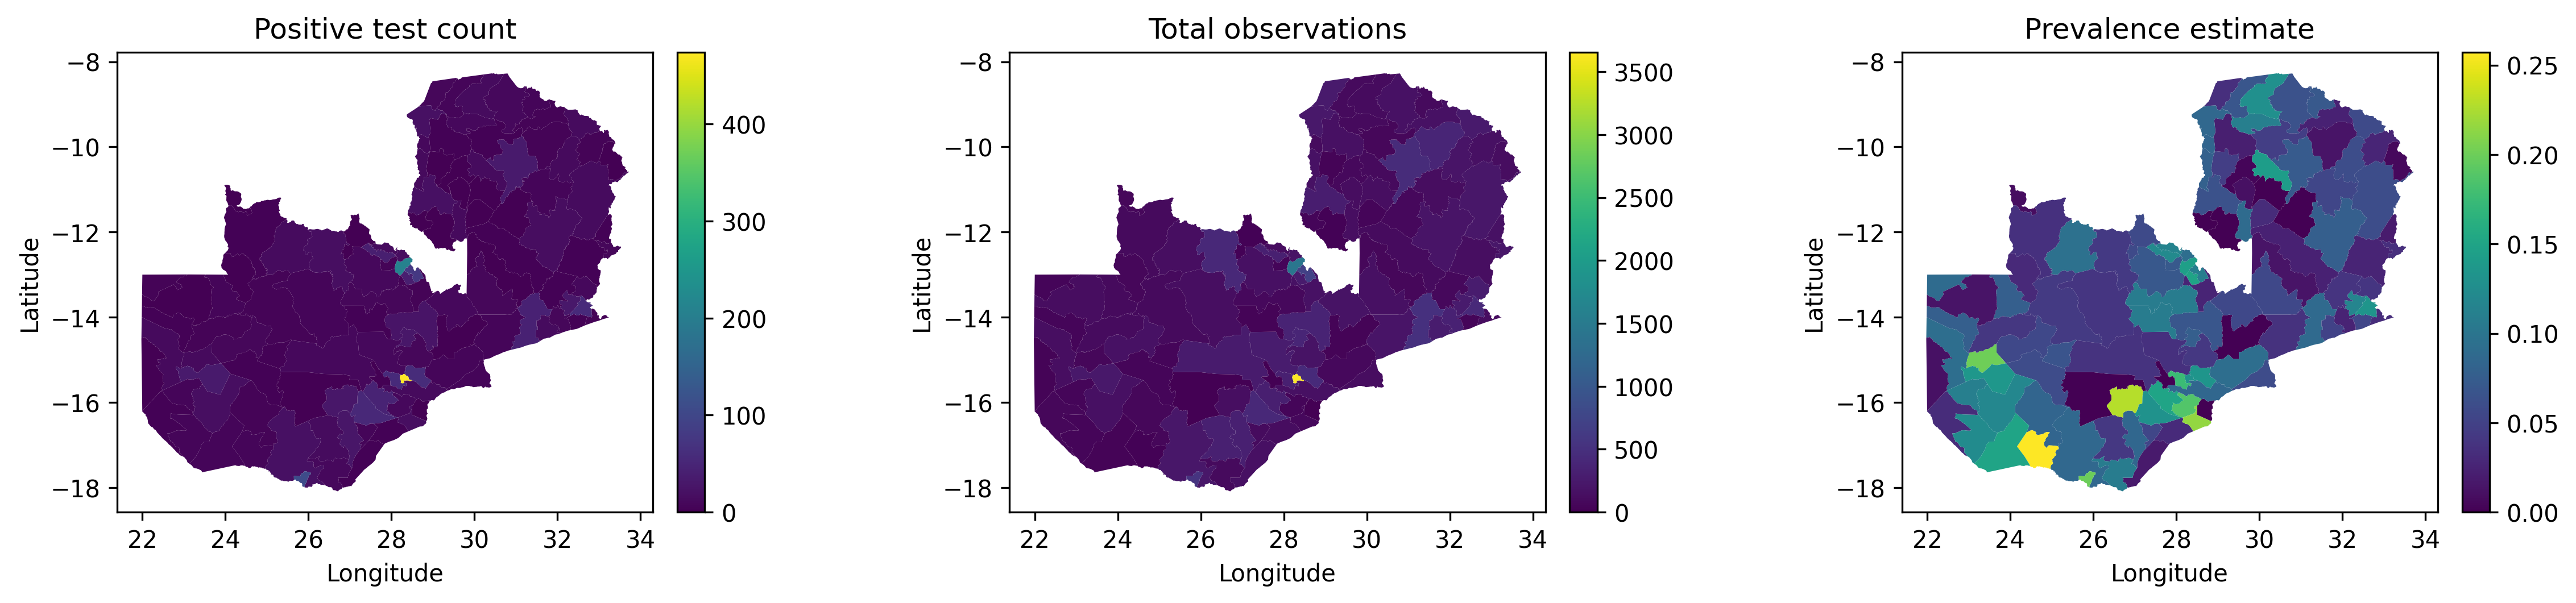

In [25]:
# Create plots for positive test count, total observations and prevalence estimate
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot the data with a consistent colorbar size
for i, column in enumerate(["Positive test count", "Total observations", "Prevalence estimate"]):
    plot = s_new_plot.plot(column=column, ax=ax[i], legend=False)
    ax[i].set_title(column)
    ax[i].set_xlabel('Longitude')
    ax[i].set_ylabel('Latitude')
    
    # Create an axis on the right side of the plot for the colorbar
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    # Create colorbar using the first collection's norm and cmap
    sm = plt.cm.ScalarMappable(cmap=plot.collections[0].cmap, norm=plot.collections[0].norm)
    sm._A = []  # Dummy array for the scalar mappable
    fig.colorbar(sm, cax=cax)

# Adjust space between plots
plt.subplots_adjust(wspace=0.5)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Save the figure as a PDF
plt.savefig(f'figures/ZMB2018_{admin_level}_observations.pdf')

In [26]:
if (admin_level==2):
    # Check y and n_obs for capital, Lusaka
    lusaka_data = s_new[s_new['area'] == 'LUSAKA']
    print(lusaka_data[['y', 'n_obs']])

      y  n_obs
58  474   3653


In [27]:
del shape_new
del infections_new

## Computational grid

In this section, we create the artificial grid over the country domain.

In [28]:
# Creation of regular grid 
x_min, x_max, y_min, y_max = 21.5, 34, -19, -8
dy = y_max - y_min
dx = x_max - x_min
factor = dy / dx
n_x = 40 
n_y = math.ceil(n_x * factor)
print(n_x)
print(n_y)
print(n_x * n_y)

x_grid = np.linspace(x_min, x_max, n_x, endpoint=True)
y_grid = np.linspace(y_min, y_max, n_y, endpoint=True)

# full coordinate arrays
x_coords, y_coords = np.meshgrid(x_grid, y_grid)
x_coords = x_coords.reshape(-1)
y_coords = y_coords.reshape(-1)

df = pd.DataFrame({'Latitude': y_coords, 'Longitude': x_coords})

grid_pts = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude))

x = jnp.array([x_coords, y_coords]).transpose((1, 0))
print(x.shape)

40
36
1440
(1440, 2)


2024-08-07 15:55:48.472039: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


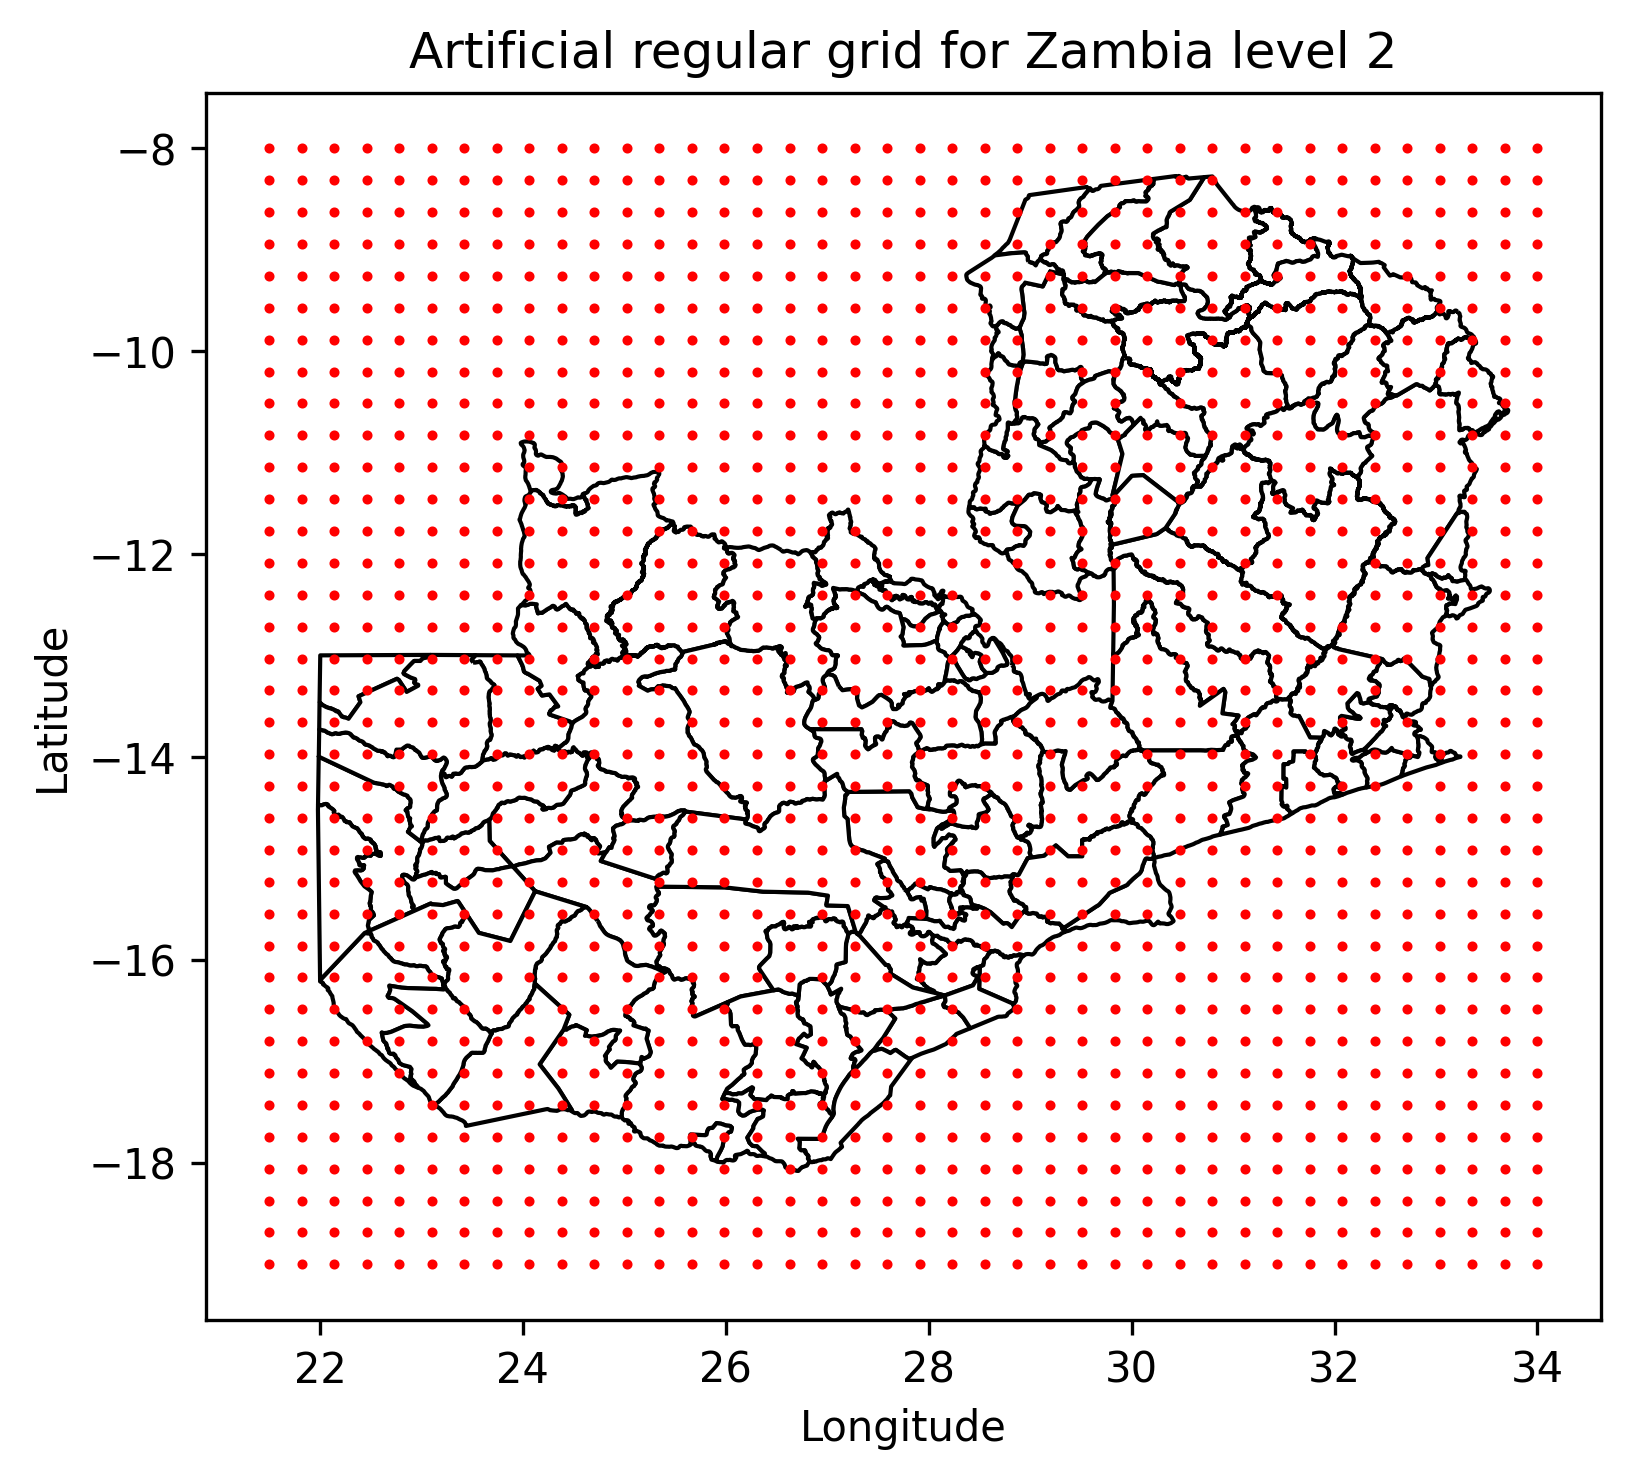

In [30]:
# Plot artificial regular grid 
fig, ax = plt.subplots(1, 1, figsize=(6,6))
divider = make_axes_locatable(ax)
s_new.plot(ax=ax, color='white', edgecolor='black')
grid_pts.plot(ax=ax, marker='o', color='red', markersize=2)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Artificial regular grid for Zambia level {admin_level}')
plt.savefig(f'figures/ZMB2018_adm{admin_level}_regular_grid.pdf')

In [31]:
# Add points at random in administrative units with less than min_points gridpoints (here set to 10)

def pol_pts(shape, grid_pts, min_pts=10):
    grid_pts.set_crs(epsg=4326, inplace=True);
    grid_pts.crs == shape.crs

    n_pol = len(shape.geometry)
    n_pts = len(grid_pts.geometry)

    pl_pt = np.zeros((n_pol, n_pts), dtype=int)

    pt_which_pol = np.zeros(n_pts, dtype=int)

    for i_pol in range(n_pol):
        pol = shape.geometry[i_pol]
        for j_pts in range(n_pts):
            pt = grid_pts.geometry[j_pts]
            if pol.contains(pt):
                pl_pt[i_pol, j_pts] = 1
                pt_which_pol[j_pts] = i_pol + 1 # note the enumeration!


    # ensure a minimum number of points

    pol_sums = np.sum(pl_pt, axis=1)

    fix_pols = np.where(pol_sums<min_pts)[0]

    if fix_pols.size > 0:

      for i_pol in fix_pols:

        # print(f'i_pol:{i_pol}')

        polygon = shape.geometry[i_pol]
        no_points = pol_sums[i_pol]

        extra_len = min_pts - no_points
        minx, miny, maxx, maxy = polygon.bounds
        extra_y_coords = []
        extra_x_coords = []

        main_rng_key = random.PRNGKey(44)

        # print(extra_len)

        while extra_len > 0:
            main_rng_key, rng_key_pts = random.split(main_rng_key)
            random_point_coords = [
                random.uniform(rng_key_pts, (1,), minval=minx, maxval=maxx)[0],
                random.uniform(rng_key_pts, (1,), minval=miny, maxval=maxy)[0]
            ]
            random_point = Point(float(random_point_coords[0]), float(random_point_coords[1]))

            if polygon.contains(random_point):
              # print('Contains random point')
              extra_y_coords.append(random_point.y)
              extra_x_coords.append(random_point.x)
              extra_len -= 1

        # add extra points to grid

        # Create DataFrame for new points
        extra_df = pd.DataFrame({'Latitude': extra_y_coords, 'Longitude': extra_x_coords})
        extra_grid_pts = gpd.GeoDataFrame(extra_df, geometry=gpd.points_from_xy(extra_df.Longitude, extra_df.Latitude))

        # Set CRS for the new GeoDataFrame
        extra_grid_pts.set_crs(epsg=4326, inplace=True)

        # Concatenate the original and new GeoDataFrames
        grid_pts = pd.concat([grid_pts, extra_grid_pts]).reset_index(drop=True)


      # Amend pl_pt and pt_which_pol (outside polygon loop)
      pl_pt, pt_which_pol, _ = pol_pts(shape, grid_pts, min_pts)

    return([pl_pt, pt_which_pol, grid_pts])

In [32]:
# assign gridpoints to corresponding administrative units

pol_pt_new, pt_which_pol_new, grid_pts_new = pol_pts(s_new, grid_pts, min_pts=10)
pol_sums_new = np.sum(pol_pt_new, axis=1) # how many points in each polygon
# print(all(item > 0 for item in pol_sums_new)) # in each polygon there is at least one point
print(all(item >= 10 for item in pol_sums_new)) # in each polygon there is at least 10 points
grid_pts_new['pt_which_pol_new'] = pt_which_pol_new
grid_pts_new

True


Latitude  Longitude                    geometry  pt_which_pol_new
0    -19.000000  21.500000  POINT (21.50000 -19.00000)                 0
1    -19.000000  21.820513  POINT (21.82051 -19.00000)                 0
2    -19.000000  22.141026  POINT (22.14103 -19.00000)                 0
3    -19.000000  22.461538  POINT (22.46154 -19.00000)                 0
4    -19.000000  22.782051  POINT (22.78205 -19.00000)                 0
...         ...        ...                         ...               ...
2013 -17.455769  26.790142  POINT (26.79014 -17.45577)               115
2014 -17.507141  26.722168  POINT (26.72217 -17.50714)               115
2015 -17.777426  26.364519  POINT (26.36452 -17.77743)               115
2016 -17.394756  26.870876  POINT (26.87088 -17.39476)               115
2017 -17.401566  26.861866  POINT (26.86187 -17.40157)               115

[2018 rows x 4 columns]

In [35]:
# create updated vector of gridpoints
new_y_coords = grid_pts_new['Latitude']
new_x_coords = grid_pts_new['Longitude']
new_x = jnp.array([new_x_coords, new_y_coords]).transpose((1, 0))
print(new_x.shape)

(2018, 2)


In [36]:
# update the grid_pts to the fuller, updated vector of gridpoints
grid_pts = grid_pts_new
grid_pts.shape


(2018, 4)

In [37]:
# assign which gridpoint belongs to which polygon 

grid_pts['in_out_new'] = grid_pts['pt_which_pol_new'].apply(lambda x: 'out' if x==0 else 'in')
grid_pts['marker_size_new'] = grid_pts['pt_which_pol_new'].apply(lambda x: 1 if x==0 else 12)
n_pol_new = len(s_new.geometry)

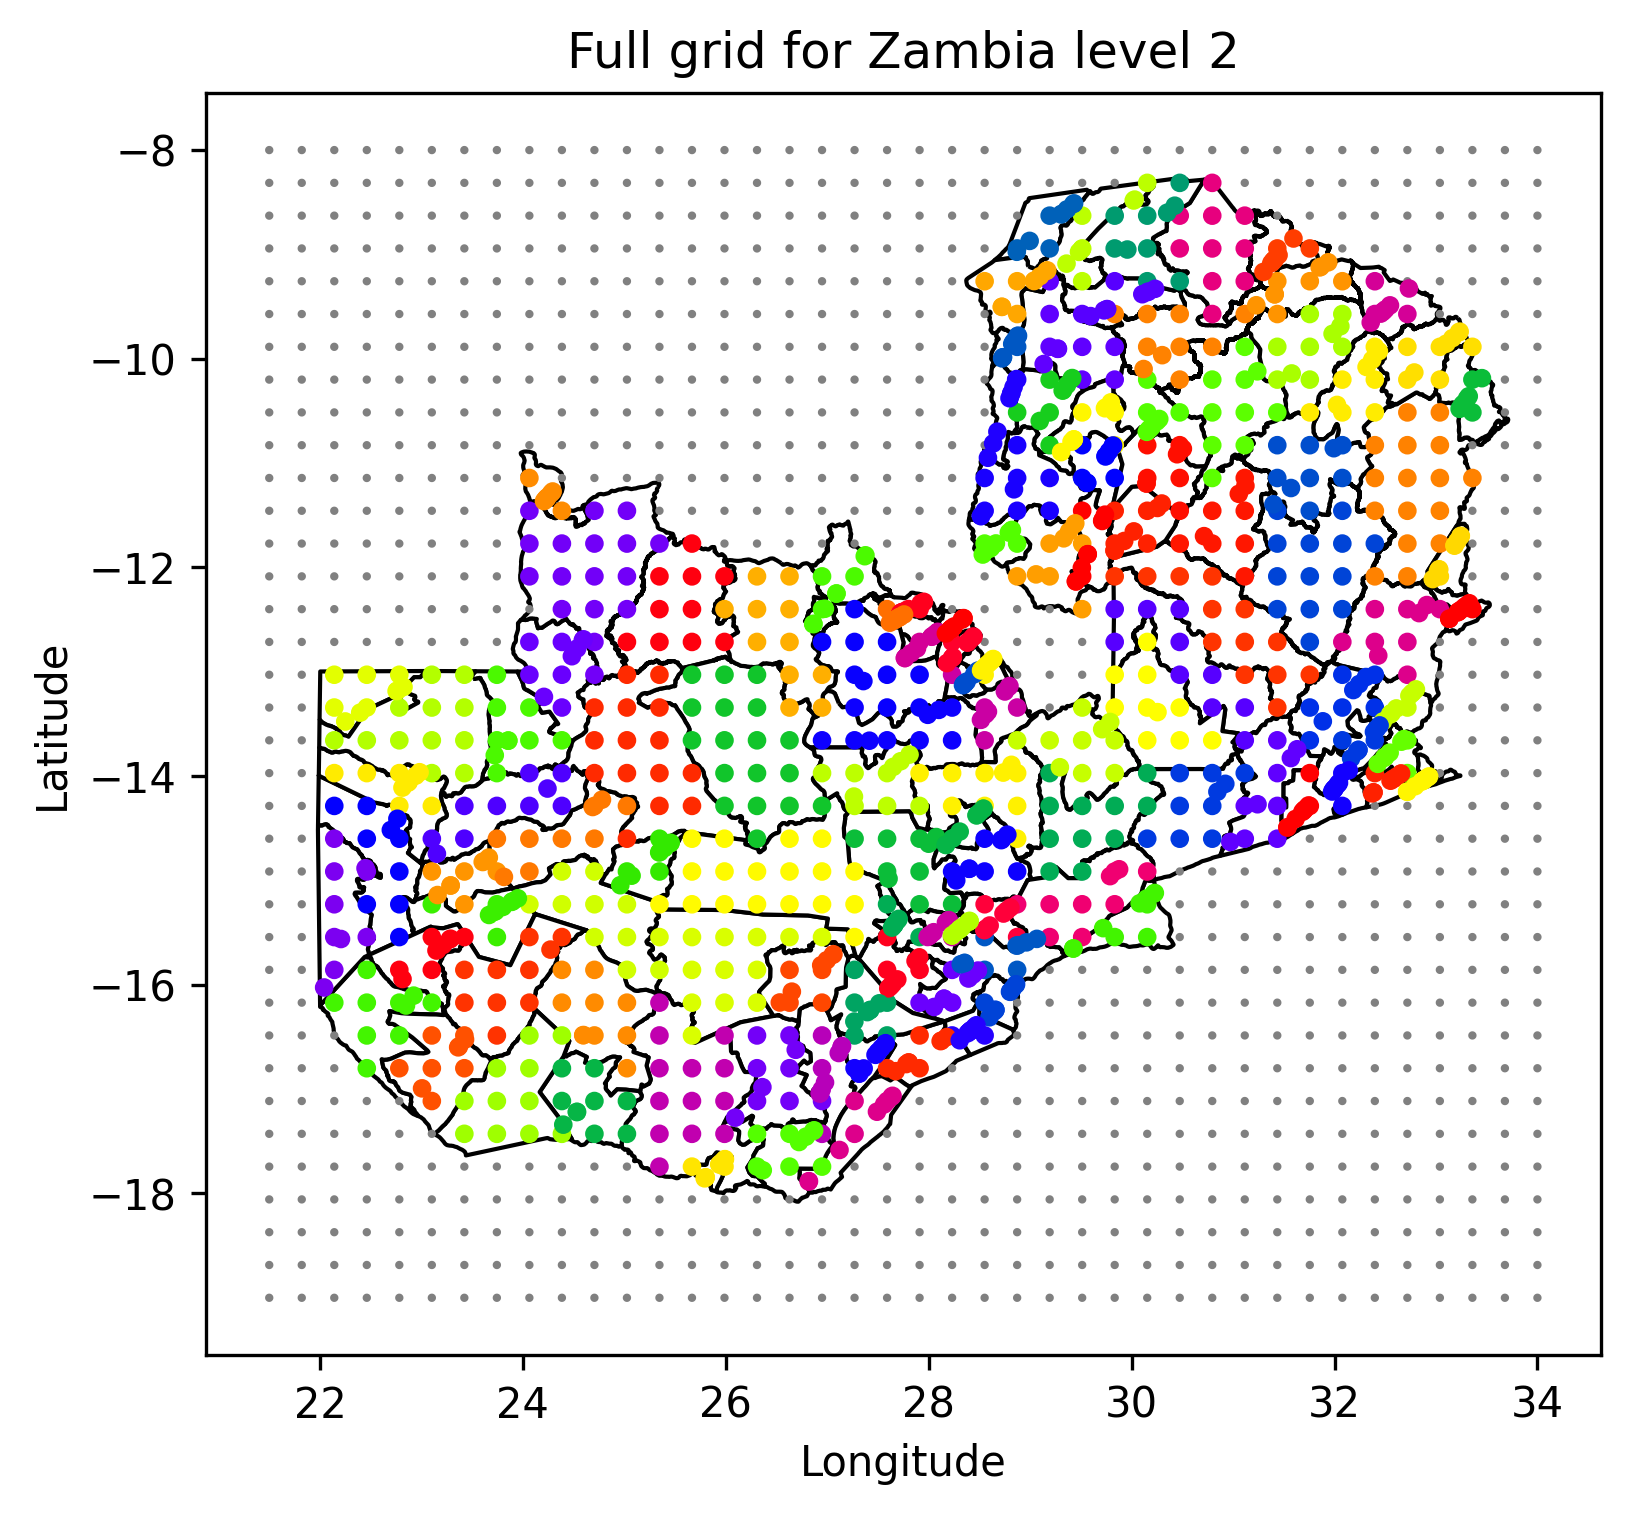

In [39]:
# Create a map of full grid, segmented by corresponding administrative unit 

cmap = plt.cm.prism  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

fig, ax2 = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6,6))
divider = make_axes_locatable(ax)

# define the bins and normalize
bounds_new = np.linspace(min(pt_which_pol_new), max(pt_which_pol_new), n_pol_new)
norm_new = matplotlib.colors.BoundaryNorm(bounds_new, cmap.N)
s_new.plot(ax=ax2, color='white', edgecolor='black')
grid_pts.plot(ax=ax2, marker='o', column='pt_which_pol_new', markersize='marker_size_new', cmap=cmap)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Full grid for Zambia level {admin_level}')
plt.savefig(f'figures/ZMB2018_adm{admin_level}_full_segmentation.pdf')

In [40]:
s_new.head(3)

area                                           geometry  new     usage  \
0  CHADIZA  POLYGON ((32.57804 -13.93448, 32.75563 -13.982...    1  0.592593   
1    CHAMA  POLYGON ((32.84411 -10.34120, 32.84790 -10.341...    1  0.656690   
2  CHASEFU  POLYGON ((32.94614 -12.21183, 32.94578 -12.211...    1  0.491268   

   n_obs   y  estimate  
0     44   2  0.054054  
1    220  13  0.059658  
2    157   3  0.018292

In [42]:
# rename columns 
s = s_new.rename({'Total observations':'n_obs', 'Positive tests count':'y', 'Prevalence estimate':'estimate'}, axis='columns')
# s = pd.concat([s_old, s_new])
s.head()
#print(s.shape)

area                                           geometry  new     usage  \
0  CHADIZA  POLYGON ((32.57804 -13.93448, 32.75563 -13.982...    1  0.592593   
1    CHAMA  POLYGON ((32.84411 -10.34120, 32.84790 -10.341...    1  0.656690   
2  CHASEFU  POLYGON ((32.94614 -12.21183, 32.94578 -12.211...    1  0.491268   
3  CHAVUMA  POLYGON ((21.99573 -13.46393, 21.99610 -13.439...    1  0.438596   
4   CHEMBE  POLYGON ((28.89259 -11.50817, 28.87754 -11.520...    1  0.826087   

   n_obs   y  estimate  
0     44   2  0.054054  
1    220  13  0.059658  
2    157   3  0.018292  
3     56   5  0.089286  
4     51   0  0.000000

# PriorCVAE 

In this section, we implement the PriorCVAE part of AggCVAE, where GP priors are approximated by the CVAE.

## Preliminary functions

In this section, we define preliminary functions for the RBF kernel of the GP prior and the indicator matrix. 

In [43]:

# define the RBF kernel of the GP prior

def dist_euclid(x, z):
    x = jnp.array(x)
    z = jnp.array(z)
    if len(x.shape)==1:
        x = x.reshape(x.shape[0], 1)
    if len(z.shape)==1:
        z = x.reshape(x.shape[0], 1)
    n_x, m = x.shape
    n_z, m_z = z.shape
    assert m == m_z
    delta = jnp.zeros((n_x,n_z))
    for d in jnp.arange(m):
        x_d = x[:,d]
        z_d = z[:,d]
        delta += (x_d[:,jnp.newaxis] - z_d)**2
    return jnp.sqrt(delta)


def exp_sq_kernel(x, z, var, length, noise, jitter=1.0e-4):
    dist = dist_euclid(x, z)
    deltaXsq = jnp.power(dist/ length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k

In [ ]:
# define the indicator matrix for the polygons

def M_g(M, g):
    '''
    - $M$ is a matrix with binary entries $m_{ij},$ showing whether point $j$ is in polygon $i$
    - $g$ is a vector of GP draws over grid
    - $maltmul(M, g)$ gives a vector of sums over each polygon
    '''
    M = jnp.array(M)
    g = jnp.array(g).T
    return(jnp.matmul(M, g))

## CVAE architecture

In this section we construct the conditional variational auto-encoders, needed to approximate the GP prior.

In [45]:
# import flax library 
from collections.abc import Callable
from typing import Iterable

import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import optax
from flax.training.train_state import TrainState
from jax import Array, value_and_grad, jit, random
from jax.scipy.stats import norm
from numpyro.infer import MCMC, NUTS
from tqdm.notebook import tqdm

In [46]:
# Setting model specifications for CVAE.
args = {"seed": 0,

        # architecture
        "hidden_dim": 1024,
        "z_dim": 512,

        # CVAE training
        "vae_sd": 1,
        "n_epochs": 100,        
        "learning_rate": 1e-3,
        "batch_size": 100,
        "save_vae": False,
        "load_vae": False,      # set to True to load trained CVAE
        "decoder_params": None,
        "hyperprior_ls_name": "Gamma(3, 10)",
        "hyperprior_var_name": "Gamma(8, 100)",
        "hyperprior_ls": dist.Gamma(3, 10),
        "hyperprior_var": dist.Gamma(8, 100),
        "rng_key": random.PRNGKey(5),

        # MCMC setup
        "num_warmup": 200,
        "num_mcmc_samples": 1000,
        "num_chains": 4,

        # data
        'n_obs': jnp.array(s.n_obs),
        "x": new_x,

        # kernel and indicator matrix
        "gp_kernel": exp_sq_kernel,
        "jitter": 1e-4,
        "M_new": pol_pt_new,
        
        # posterior analysis
        "num_samples_posterior": 1000,
       }

In [47]:
# model specification string for future saving 
model_specs =('_admin' + str(admin_level)+
              '_mcmcsamp' + str(args['num_mcmc_samples'])+
             '_h' + str(args["hidden_dim"])+
             '_z' + str(args["z_dim"])+
             '_epochs' + str(args["n_epochs"])+
             '_ls' + args['hyperprior_ls_name']+
             '_var' + args['hyperprior_var_name'])
print('Model specifications:', model_specs)

Model specifications: _admin2_mcmcsamp1000_h1024_z512_epochs100_lsGamma(3, 10)_varGamma(8, 100)


In [48]:
# Create the new directory
os.makedirs('figures/ZMB2018_aggCVAE'+model_specs, exist_ok=True)

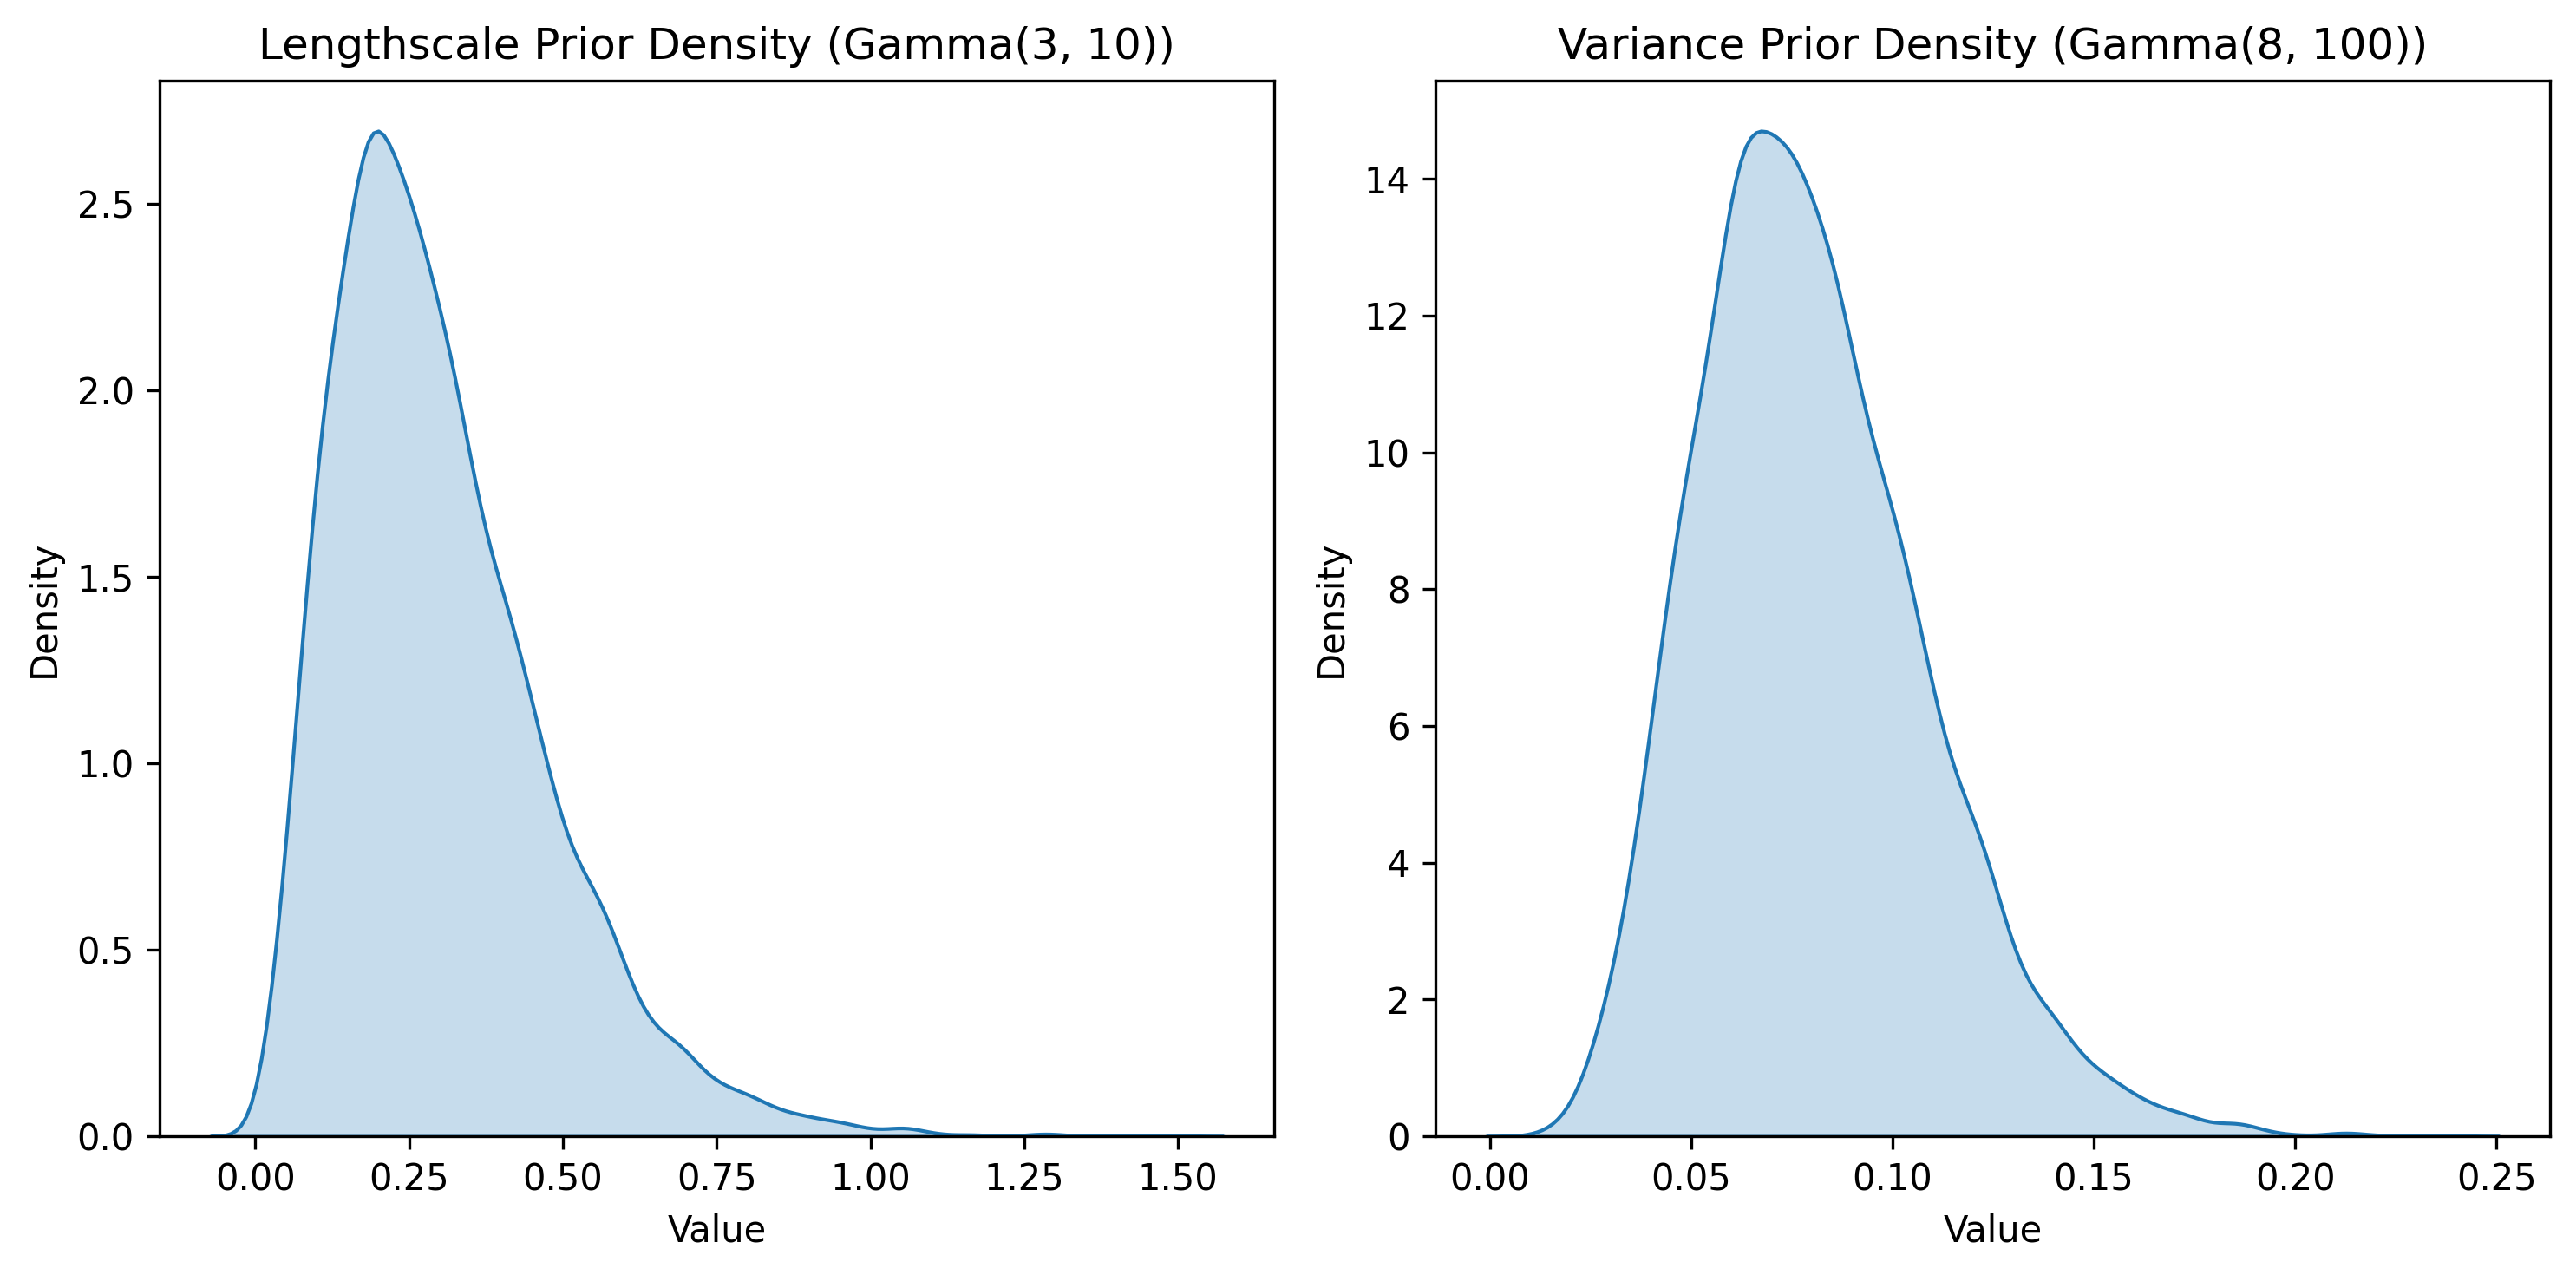

In [49]:
# Plot of the hyperpriors
import matplotlib.pyplot as plt
import seaborn as sns
import jax.random as random

# Set random seed for reproducibility
rng_key = random.PRNGKey(0)

# Define the distribution for args
dist_ls = args['hyperprior_ls']
dist_var = args['hyperprior_var']

# Sample from the distribution
samples_ls = dist_ls.sample(rng_key, (10000,))
samples_var = dist_var.sample(rng_key, (10000,))

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Create a figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Adjust the figsize as needed

# Plot the Lengthscale density
sns.kdeplot(samples_ls, ax=axs[0], fill=True)
axs[0].set_title(f'Lengthscale Prior Density ({args["hyperprior_ls_name"]})')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Density')

# Plot the Variance density
sns.kdeplot(samples_var, ax=axs[1], fill=True)
axs[1].set_title(f'Variance Prior Density ({args["hyperprior_var_name"]})')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Density')

# Save
plt.tight_layout()
plt.savefig('figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+model_specs+ '_hyperprior_distributions.pdf')
plt.show()

In [50]:
# define the Multi-Layer Perceptron class: code from DJ 

from collections.abc import Callable
from flax import linen as nn


class MLP(nn.Module):
    dims: list[int]
    act_fn: Callable = nn.relu
    p_dropout: float = 0.0

    @nn.compact
    def __call__(self, x, training: bool = False):
        for dim in self.dims[:-1]:
            x = nn.Dense(dim)(x)
            x = self.act_fn(x)
            x = nn.Dropout(self.p_dropout, deterministic=not training)(x)
        return nn.Dense(self.dims[-1])(x)

In [51]:
# define the PriorCVAE class: code from DJ 

#!/usr/bin/env python3
import jax.numpy as jnp
from flax import linen as nn
from jax import Array, random


class PriorCVAE(nn.Module):
    r"""[PriorCVAE](https://arxiv.org/pdf/2304.04307) approximates a Gaussian Process.

    Once trained, the module's `decoder` can be used as a generative
    model to simulate a GP from the samples it was trained on.

    Args:
        encoder: A module used to encode GP realizations and
            their hyperparamters.
        decoder: A module used to decode random vectors and
            GP hyperparameters into GP samples.
        z_dim: The size of the hidden dimension.

    Returns:
        An instance of the PriorCVAE network.
        $\hat{\mathbf{f}}$, a recreation of the original $\mathbf{f}$,
        along with $\mu$ and $\log(\sigma^2)$, which are often used
        to calculate losses involving KL divergence.
    """

    encoder: nn.Module
    decoder: nn.Module
    z_dim: int

    @nn.compact
    def __call__(self, rng: Array, var: float, ls: float, f: Array):
        r"""Run module forward.

        Args:
            rng: A pseudo-random number generator.
            var: The variance for the GP.
            ls: The lengthscale for the GP.
            f: The function values, an array of shape `(B, K, 1)`.

        Returns:
            $\hat{\mathbf{f}}$, a recreation of the original$\mathbf{f}$,
            along with $\mu$ and $\log(\sigma^2)$, which are often used
            to calculate losses involving KL divergence.
        """
        batch_size = f.shape[0]
        var = jnp.full((batch_size, 1), var)
        ls = jnp.full((batch_size, 1), ls)
        f_flat = f.reshape(batch_size, -1)
        latents = self.encoder(jnp.hstack([f_flat, var, ls]))
        mu = nn.Dense(self.z_dim)(latents)
        log_var = nn.Dense(self.z_dim)(latents)
        std = jnp.exp(log_var / 2)
        eps = random.normal(rng, log_var.shape)
        z = mu + std * eps
        f_hat = self.decoder(jnp.hstack([z, var, ls]))
        return f_hat.reshape(f.shape), mu, log_var
    
    def decode(self, z: Array, var: float, ls: float):
        B = z.shape[0]
        var = jnp.full((B, 1), var)
        ls = jnp.full((B, 1), ls)
        return self.decoder(jnp.hstack([z, var, ls]))

# Train CVAE

In [55]:
# define the aggregated GP priors using numpyro
 
def gp_aggr(args):

    x = args["x"]
    gp_kernel=args["gp_kernel"]
    jitter = args["jitter"]
    M_new = args["M_new"]

    # random effect - aggregated GP
    length = numpyro.sample("kernel_length", args['hyperprior_ls'])
    variance = numpyro.sample("kernel_var", args['hyperprior_var'])
    k = gp_kernel(x, x, variance, length, jitter)
    f = numpyro.sample("f", dist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))

    # aggregate f into gp_aggr according to indexing of (point in polygon)
    gp_aggr_new = numpyro.deterministic('gp_aggr_new', M_g(M_new, f))
    gp_aggr = numpyro.deterministic('gp_aggr', gp_aggr_new)
    ls = numpyro.deterministic('ls', length)
    var = numpyro.deterministic('var', variance)

In [57]:
# sample from the aggregated GP priors
rng_key, rng_key_ = random.split(random.PRNGKey(4))
agg_gp_predictive = Predictive(gp_aggr, num_samples=args['num_samples_posterior'])
agg_gp_preds = agg_gp_predictive(rng_key_, args)
agg_gp_draws = agg_gp_preds['gp_aggr_new']
ls_draws = agg_gp_preds['ls']
var_draws = jnp.array(agg_gp_preds['var'])

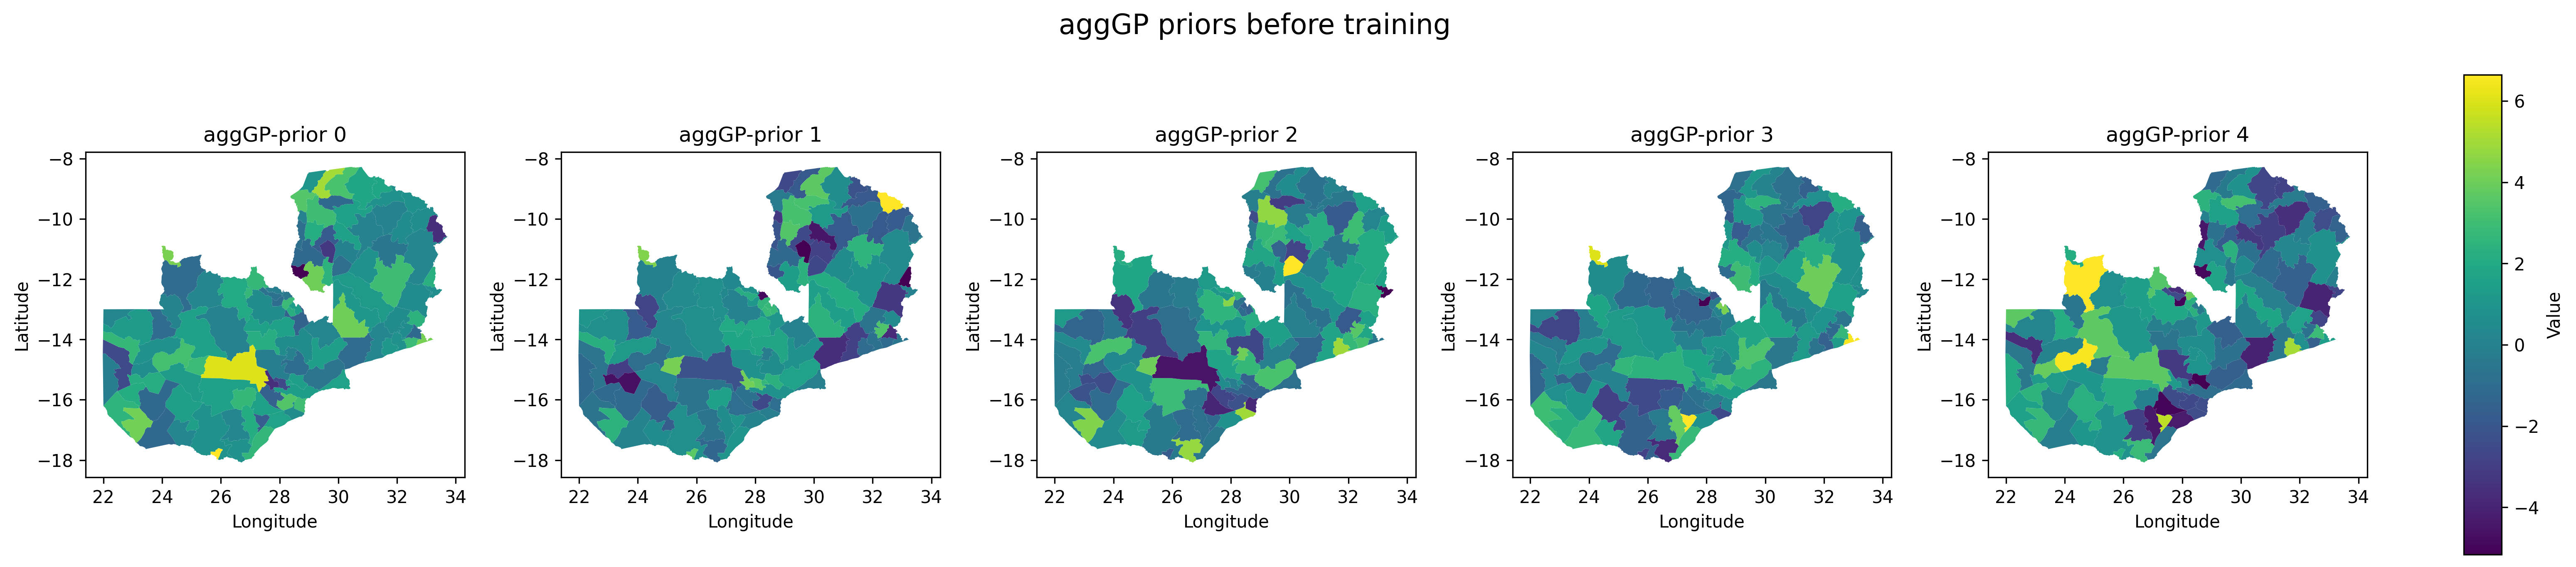

In [62]:
# plot the aggregated GP priors before training

import matplotlib.gridspec as gridspec

s_new_plot = s.copy()

# Create a figure with a gridspec
fig = plt.figure(figsize=(25, 5))
gs = gridspec.GridSpec(1, 6, width_ratios=[1, 1, 1, 1, 1, 0.1], wspace=0.3)  # Adjust wspace for more horizontal space

axs = [fig.add_subplot(gs[i]) for i in range(5)]

# Plot each column in a separate subplot
for i in range(5):
    nm = 'gp_aggr_' + str(i)
    s_new_plot[nm] = agg_gp_draws[i, :]
    s_new_plot.plot(column=nm, ax=axs[i], legend=False)
    axs[i].set_xlabel('Longitude')
    axs[i].set_ylabel('Latitude')
    axs[i].set_title(f'aggGP-prior {i}')

# Add an overall title
fig.suptitle('aggGP priors before training', fontsize=16)

# Create a colorbar
cbar_ax = fig.add_subplot(gs[5])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=s_new_plot[nm].min(), vmax=s_new_plot[nm].max()))
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar_ax.set_ylabel('Value')

# Save the figure
plt.savefig('figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+model_specs+'_aggGP_priors_before_training.pdf')
plt.show()

In [63]:
# define a data class to later construct a dataloader of the aggregated GP priors

class aggCVAED:
  def __init__(self, n_samples, x, model_args):
    self.n_samples = n_samples
    self.args = model_args
    self.x, self.y, self.ls, self.var = self._sampledata()

  def __len__(self):
    return self.n_samples

  def __getitem__(self, idx=0):
    return(self.x[idx], self.y[idx], self.ls[idx], self.var[idx])

  def _sampledata(self):
    # rng_key = rnd.randint(0, 912393890428)
    rng_key = 0
    rng_key, rng_key_ = random.split(random.PRNGKey(rng_key))
    agg_gp_predictive = Predictive(gp_aggr, num_samples=self.n_samples)
    all_draws = agg_gp_predictive(rng_key, self.args)

    ls_draws = all_draws['ls']
    ls_draws = jnp.array(ls_draws.reshape(ls_draws.shape[0], 1))
    
    gp_draws = all_draws['gp_aggr']
    gp_draws = jnp.array(gp_draws.reshape(gp_draws.shape[0], gp_draws.shape[1], 1))
    
    var_draws = all_draws['var']
    var_draws = jnp.array(var_draws.reshape(var_draws.shape[0], 1))
    
    x_repeated = np.tile(x, (self.n_samples, 1, 1))
    # x_repeated is of the shape (n_samples, N, D), where N is number of datapoints, D is dimensionality
    # return (x.repeat(self.n_samples).reshape(x.shape[0], self.n_samples).transpose(), gp_draws, ls_draws)
    return (x_repeated, gp_draws, ls_draws, var_draws)


In [64]:
# create a dataloader of the aggregated GP priors to be then used in training

from collections.abc import Callable
from typing import Iterable

import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import optax
from flax.training.train_state import TrainState
from jax import Array, value_and_grad, jit, random
from jax.scipy.stats import norm
from numpyro.infer import MCMC, NUTS
from tqdm.notebook import tqdm


def dataloader(dataset, batch_size, shuffle=True):
    indices = np.arange(len(dataset))
    if shuffle:
        np.random.shuffle(indices)
    
    for start_idx in range(0, len(dataset), batch_size):
        batch_indices = indices[start_idx:start_idx + batch_size]
        batch = [dataset[idx] for idx in batch_indices]
        x_batch, y_batch, ls_batch, var_batch = zip(*batch)
        yield (jnp.array(x_batch), jnp.array(y_batch), jnp.array(ls_batch), jnp.array(var_batch))

In [65]:
# define a function for training, code is extended from DJ's code 


def train(
    rng: jax.Array,
    model: nn.Module,
    train_step: Callable,
    n_samples: int,
    x: jax.Array,
    model_args,
    batch_size: int = 1024,
    num_epochs: int = 1000,
    n_samples_val: int = 100,
    checkpoint_path: str = "checkpoints_dir",
):
    

    rng_init, rng_z, rng_train = random.split(rng, 3)

    # define dataset and dataloader
    dataset = aggCVAED(n_samples=n_samples, x=x, model_args=model_args)
    loader = dataloader(dataset, batch_size=batch_size, shuffle=True)

    _s, f, ls, var = next(loader)
    
    state = TrainState.create(
        apply_fn=model.apply,
        params=model.init(rng_init, rng_z, var, ls, f)["params"],
        tx=optax.adam(1e-3),
    )
    
    is_decoder_only = False
    
    num_batches = n_samples // batch_size
    
    losses = np.zeros((num_batches,))
    avg_losses = np.zeros((num_epochs,))
    val_avg_losses = np.zeros((num_epochs,))
    
    start_epoch = 0
    
    for epoch in (pbar := tqdm(range(start_epoch, num_epochs), dynamic_ncols=True)):
        # re-initialise loader
        loader = dataloader(dataset, batch_size=batch_size, shuffle=True)
        for i, batch in enumerate(loader):
            rng_step, rng_train = random.split(rng_train)
            state, losses[i] = train_step(rng_step, state, batch)
        
        # calculate train loss every epoch
        avg = jnp.mean(losses)
        avg_losses[epoch] = avg
        pbar.set_postfix(loss=f"Epoch: {epoch}, Train loss: {avg:.3f}")
        # wandb.log({"epoch_train_loss": avg})
        
        # validate every epoch
        rng_valid, rng_train = random.split(rng_train)
        val_avg_losses[epoch] = validate(rng_valid, 
                                  x, 
                                  state, 
                                  model_args, 
                                  n_samples_val,
                                  epoch=epoch,
                                  numb_epochs=num_epochs,
                                  decoder_only=is_decoder_only, 
                                  wandb_key=f"Epoch {epoch}")
        # reset losses vector for next epoch
        losses = np.zeros((num_batches,))

    return state, loader, avg_losses, val_avg_losses

2024-08-07 15:56:01.463752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 15:56:01.470734: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 15:56:01.472692: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 15:56:01.893749: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [66]:
# define a function for training, code is extended from DJ's code 

def validate(
    rng: jax.Array,
    x: jax.Array,
    state: TrainState,
    model_args,
    n_samples: int,
    epoch: int,
    numb_epochs: int = 1000,
    decoder_only: bool = False,
    batch_size: int = 100,
    #num_plots: int = 16,
    wandb_key: str = "",
    results_path: Optional[Path] = None,
):
    rng_data, rng_latent_z, rng_plots = random.split(rng, 3)
    
    # define dataset and dataloader
    dataset = aggCVAED(n_samples=n_samples, x=x, model_args=model_args)
    loader = dataloader(dataset, batch_size=batch_size, shuffle=True)
    
    num_batches = n_samples // batch_size
    losses = np.zeros((num_batches,))
    results = []
    for i, batch in enumerate(loader):
        z, f, ls, var = batch
        params = {"params": state.params}
        # rngs = {"latent_z": rng_latent_z}
        if decoder_only:
            f_hat = jit(state.apply_fn)(params, var, ls, f)
            losses[i] = optax.squared_error(f_hat, f.squeeze()).mean()
        else:
            f_hat, z_mu, z_log_var = state.apply_fn(params, rng_latent_z, var, ls, f)
            kl_div = (0.5 * (jnp.exp(z_log_var) + jnp.square(z_mu) - 1 - z_log_var)).mean()
            logp = norm.logpdf(f, f_hat, 1.0).mean()
        
        
            losses[i] = -logp + kl_div
            # print(losses[i])
        if results_path:
            b = [np.array(v) for v in batch]
            p = np.array(f_hat)
            results += [(b, p)]
    loss = losses.mean()
    print(f"Epoch: {epoch}, Validation loss: {loss:.3f}")
    # wandb.log({"validation_loss": loss})
    if results_path:
        with open(results_path, "wb") as f:
            pickle.dump(results, f)
    return loss

In [67]:
# functions to build the CVAE architecture, and to define the loss function during training

# CVAE architecture
def build_prior_cvae(num_s: int = 64, z_dim: int = 64, hidden_dim: int = 256):
    encoder = MLP([hidden_dim, z_dim])
    decoder = MLP([hidden_dim, num_s])
    return PriorCVAE(encoder, decoder, z_dim)

# loss function
@jit
def prior_cvae_train_step(rng, state, batch):
    def elbo_loss(params):
        _s, f, ls, var  = batch
        f_hat, z_mu, z_log_var = state.apply_fn({"params": params}, rng, var, ls, f)
        kl_div = (0.5 * (jnp.exp(z_log_var) + jnp.square(z_mu) - 1 - z_log_var)).mean()
        logp = norm.logpdf(f, f_hat, 1.0).mean()
        return -logp + kl_div

    loss, grads = value_and_grad(elbo_loss)(state.params)
    return state.apply_gradients(grads=grads), loss

In [69]:
# model arguments
model_args = args
n_samples = args['samples']
num_epochs = args['n_epochs']
x = args['x']

# num_s is 10 for admin 1 because there are 10 polygons, i.e. the K in (B, K, 1)
if admin_level == 1:
    num_s = 10
if admin_level == 2: # num_s is 115 for admin 1 because there are 115 polygons
    num_s  = 115

batch_size = args['batch_size']

In [70]:
# random keys for reproducibility
key = random.key(0)
rng_data, rng_train, rng_z = random.split(key, 3)


# build priorCVAE
prior_cvae = build_prior_cvae(num_s, z_dim=args['z_dim'], hidden_dim=args['hidden_dim'])

# path has to be absolute for orbax checkpoint manager
checkpoint_path =  os.path.abspath(os.path.join('training_checkpoints',
                                f'AggCVAE_admin{admin_level}_checkpoint'+
                               model_specs))

checkpoint_path

'/auto/users/selden/my_code/aggVAE_colab/training_checkpoints/AggCVAE_admin2_checkpoint_admin2_mcmcsamp1000_h1024_z512_epochs100_lsGamma(3, 10)_varGamma(8, 100)'

In [71]:
# train CVAE

state, loader, train_losses, val_losses = train(rng_train, 
                                                prior_cvae, 
                                                prior_cvae_train_step, 
                                                n_samples, 
                                                x, 
                                                model_args, 
                                                batch_size,
                                                num_epochs, 
                                                checkpoint_path=checkpoint_path)
        

  0%|                                                   | 0/100 [00:00<?, ?it/s]

Epoch: 0, Validation loss: 2.546
Epoch: 1, Validation loss: 2.260
Epoch: 2, Validation loss: 2.124
Epoch: 3, Validation loss: 2.053
Epoch: 4, Validation loss: 2.001
Epoch: 5, Validation loss: 1.970
Epoch: 6, Validation loss: 1.942
Epoch: 7, Validation loss: 1.931
Epoch: 8, Validation loss: 1.909
Epoch: 9, Validation loss: 1.889
Epoch: 10, Validation loss: 1.884
Epoch: 11, Validation loss: 1.870
Epoch: 12, Validation loss: 1.852
Epoch: 13, Validation loss: 1.827
Epoch: 14, Validation loss: 1.844
Epoch: 15, Validation loss: 1.806
Epoch: 16, Validation loss: 1.800
Epoch: 17, Validation loss: 1.793
Epoch: 18, Validation loss: 1.777
Epoch: 19, Validation loss: 1.757
Epoch: 20, Validation loss: 1.757
Epoch: 21, Validation loss: 1.725
Epoch: 22, Validation loss: 1.716
Epoch: 23, Validation loss: 1.696
Epoch: 24, Validation loss: 1.680
Epoch: 25, Validation loss: 1.658
Epoch: 26, Validation loss: 1.667
Epoch: 27, Validation loss: 1.641
Epoch: 28, Validation loss: 1.627
Epoch: 29, Validation lo

In [72]:
val_losses

array([2.54625726, 2.25978589, 2.12430811, 2.05311251, 2.00053596,
       1.97022009, 1.94225395, 1.93148196, 1.90886188, 1.88908315,
       1.88391447, 1.8699286 , 1.85242617, 1.82707977, 1.844347  ,
       1.80610108, 1.80012345, 1.79254007, 1.77699661, 1.75728321,
       1.75664711, 1.72532964, 1.71601081, 1.69576323, 1.67965627,
       1.65831256, 1.6666652 , 1.64121342, 1.62659597, 1.61162031,
       1.60077477, 1.59391093, 1.58681011, 1.5781132 , 1.57108343,
       1.56444395, 1.56167293, 1.55145156, 1.54884303, 1.54333317,
       1.52473426, 1.53571391, 1.5266118 , 1.53368235, 1.52355862,
       1.52604914, 1.52008212, 1.51857233, 1.50986075, 1.50976527,
       1.50452411, 1.50293875, 1.50123   , 1.51082003, 1.50199008,
       1.49559474, 1.49928403, 1.49995422, 1.49254346, 1.50409508,
       1.50461662, 1.50074172, 1.49475813, 1.49413288, 1.49374878,
       1.49684477, 1.4910233 , 1.49160933, 1.49406242, 1.48695397,
       1.48819089, 1.49011183, 1.48994076, 1.49691844, 1.48951

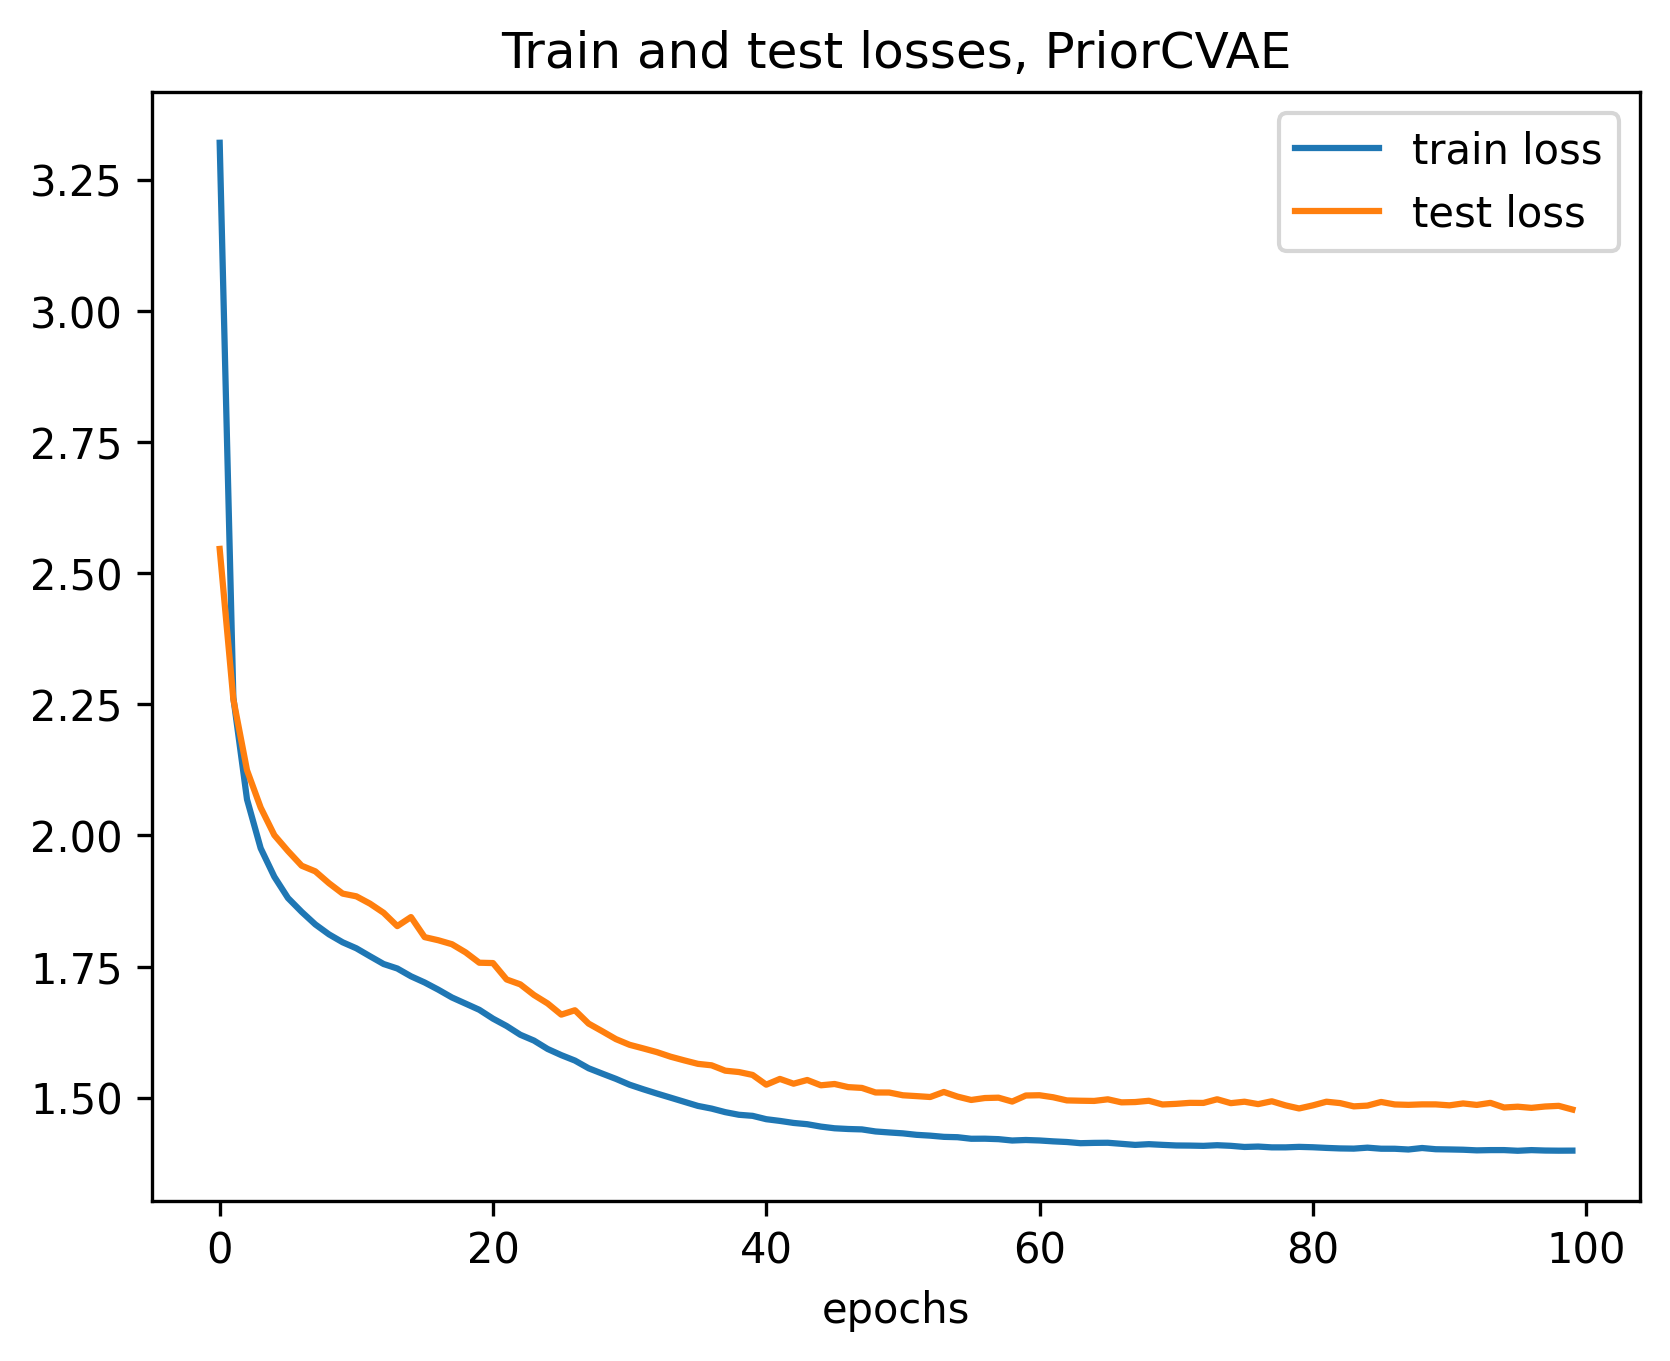

In [73]:
# plot losses
plt.plot(np.arange(0, len(train_losses), 1), train_losses, label="train loss")
plt.plot(np.arange(0, len(val_losses), 1), val_losses, label="test loss")
plt.xlabel("epochs")
plt.legend()
plt.title("Train and test losses, PriorCVAE")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig('figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+model_specs+'_loss_complete.pdf')
    

In [74]:
state.params

{'Dense_0': {'bias': Array([ 6.60979599e-02,  3.08764540e-02,  8.08183290e-03,  8.31006989e-02,
          1.27675399e-01,  6.18548431e-02,  7.42352977e-02, -1.19902462e-01,
          5.03660329e-02,  2.30197366e-02, -4.09032255e-02, -2.05835942e-02,
          2.07317788e-02, -4.34933640e-02,  2.01008439e-01, -6.92034513e-02,
         -1.04680866e-01, -1.66541189e-02,  1.87543351e-02, -8.49962085e-02,
          2.63961013e-02, -7.80691281e-02,  3.62163261e-02,  1.32954076e-01,
         -4.42287177e-02,  1.80016328e-02,  6.84299022e-02, -6.93577230e-02,
         -2.86258361e-03,  3.11761014e-02, -1.28096610e-01, -1.19091921e-01,
         -4.25614789e-02,  9.41257738e-03, -9.40981954e-02, -3.87595530e-04,
          4.95079271e-02,  2.07696453e-01,  1.15048297e-01, -4.90803272e-02,
          1.14330105e-01, -2.90695988e-02,  6.48258850e-02,  1.30786210e-01,
         -6.07855916e-02, -1.43136189e-03,  1.44067541e-01,  6.06944412e-03,
         -4.93668467e-02,  5.74447261e-03, -1.13750780e-0

In [75]:
state.params["decoder"]['Dense_0']['kernel'].shape

(514, 1024)

In [78]:
# Save decoder parameters
decoder_params = state.params["decoder"]
args["decoder_params"] = decoder_params

# Save name
model_save_name = f'aggCVAE_decoder' + model_specs
PATH = F"decoders/{model_save_name}"
PATH_loss = F"losses/{model_save_name}"

In [79]:
# Save decoder
with open(PATH, 'wb') as file:
   pickle.dump(decoder_params, file)

with open(PATH_loss, 'wb') as file:
   pickle.dump({'train_losses':train_losses, 'val_losses':val_losses}, file)

In [80]:
# Load decoder
with open(PATH, 'rb') as file:
   decoder_params = pickle.load(file)
   print(len(decoder_params))

args["decoder_params"] = decoder_params

2


In [81]:
# Load losses
with open(PATH_loss, 'rb') as file:
   losses_save = pickle.load(file)

train_losses_save = losses_save['train_losses']
val_losses_save = losses_save['val_losses']

print(losses_save)

{'train_losses': array([3.32072997, 2.26277733, 2.0687325 , 1.97557092, 1.92122221,
       1.88059592, 1.85426331, 1.83029187, 1.81134987, 1.79623687,
       1.78482306, 1.7696563 , 1.7548126 , 1.74626923, 1.73141384,
       1.71961391, 1.70588851, 1.690997  , 1.67927909, 1.66751206,
       1.65069926, 1.6366154 , 1.61995912, 1.60885072, 1.59286094,
       1.58107448, 1.57071221, 1.55603969, 1.5458163 , 1.53581035,
       1.52467978, 1.51600611, 1.50783265, 1.5       , 1.4921174 ,
       1.48425531, 1.47914636, 1.47236693, 1.46734774, 1.46532977,
       1.45892358, 1.45565629, 1.45179164, 1.44937348, 1.44480348,
       1.44160259, 1.44023287, 1.43946779, 1.43553865, 1.43363702,
       1.43191767, 1.42911398, 1.42756343, 1.42525828, 1.42458618,
       1.42161918, 1.42174554, 1.42086041, 1.41828668, 1.41925347,
       1.41834939, 1.41668177, 1.41542494, 1.41316009, 1.4137634 ,
       1.41398919, 1.41197479, 1.40990126, 1.41131783, 1.40999234,
       1.40881753, 1.40860593, 1.40808773, 1.

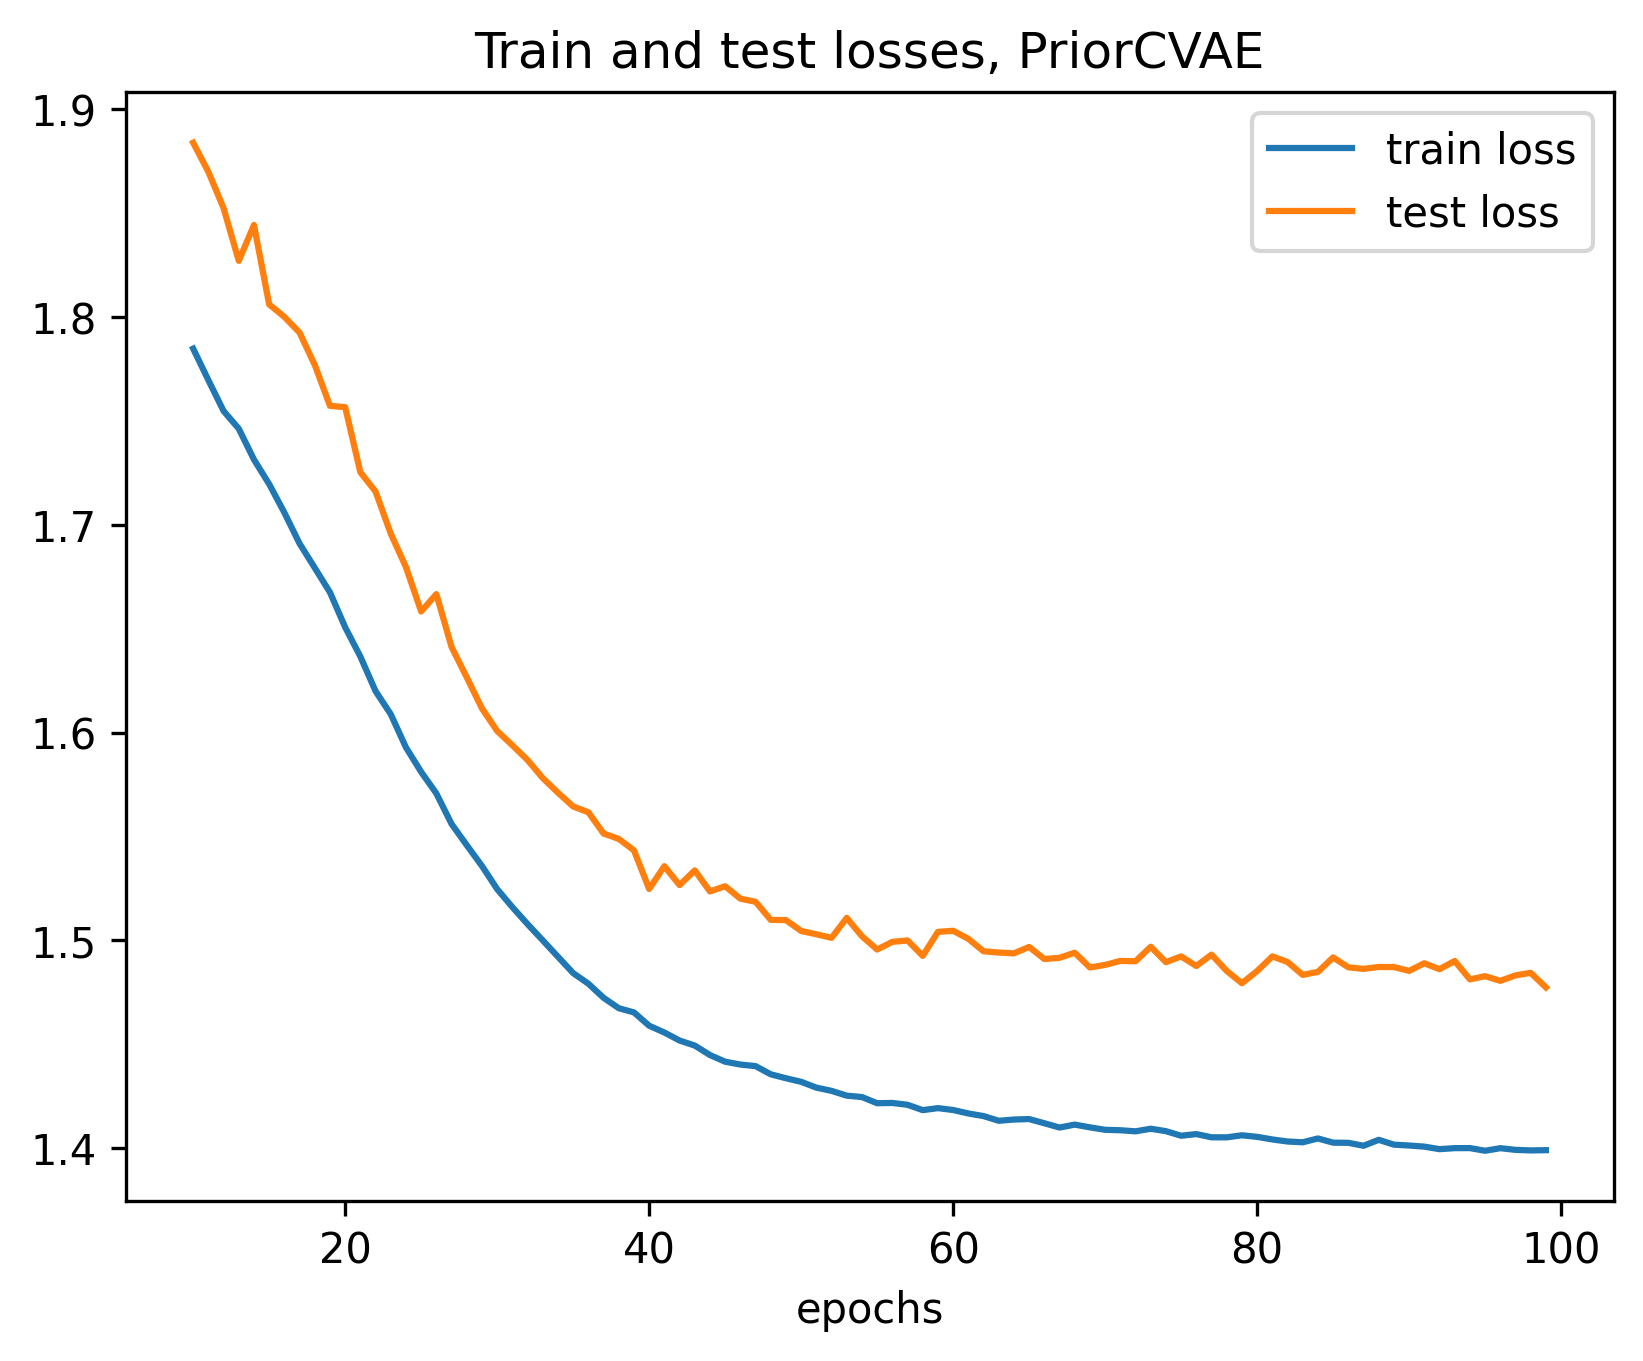

In [82]:
# Plot a shortened version of losses
plt.plot(np.arange(10, len(train_losses_save), 1), train_losses_save[10:], label="train loss")
plt.plot(np.arange(10, len(val_losses_save), 1), val_losses_save[10:], label="test loss")
plt.xlabel("epochs")
plt.legend()
plt.title("Train and test losses, PriorCVAE")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig('figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+model_specs+'_loss_short.pdf')

In [85]:
# Create dictionary of decoder parameters
decode_dict = {'decoder': decoder_params}
decode_dict

{'decoder': {'Dense_0': {'bias': Array([0.08347852, 0.07656816, 0.10081232, ..., 0.10204445, 0.05578081,
          0.10593744], dtype=float32),
   'kernel': Array([[ 0.13574134,  0.00599532, -0.04579539, ...,  0.02332337,
           -0.25211224,  0.14636451],
          [-0.11225866, -0.07560623, -0.08416568, ..., -0.022072  ,
           -0.00611064,  0.11199328],
          [-0.0135074 ,  0.00511307,  0.01633397, ...,  0.00227232,
           -0.01652543, -0.0015779 ],
          ...,
          [-0.01270478,  0.00608835, -0.00053522, ...,  0.01394176,
            0.00403088, -0.01267357],
          [ 0.19915022,  0.2158405 ,  0.14849742, ...,  0.24884763,
            0.10915895,  0.18311198],
          [ 0.15546882,  0.12890853,  0.21868812, ...,  0.1415176 ,
            0.15283401, -0.02985407]], dtype=float32)},
  'Dense_1': {'bias': Array([-0.0023622 , -0.01724407, -0.00818125,  0.00939065,  0.00230882,
           0.01817168, -0.01551139,  0.0183146 , -0.02350465, -0.00618056,
        

In [86]:
# Create a function to sample from the CVAE-approximated GP priors after CVAE training

def vae_sample(args):

    decoder_params = args["decoder_params"]
    z_dim_cond, hidden_dim = decoder_params['Dense_0']['kernel'].shape
    z_dim = z_dim_cond - 2   # z_dim_cond includes both lengthscale and variance

    # will have to change to match closer to reality
    var = numpyro.sample("var", args['hyperprior_var'])
    ls = numpyro.sample("ls", args['hyperprior_ls'])
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    z = z.reshape(1, z.shape[0])
    
    prior_cvae_sample = build_prior_cvae(num_s, z_dim=args['z_dim'], hidden_dim = args['hidden_dim'])
    decoder_nn = prior_cvae_sample.apply({"params": {'decoder': decoder_params}}, z, var, ls, method='decode')
    vae_aggr = numpyro.deterministic("vae_aggr", decoder_nn)

In [87]:
# Sample from the CVAE-approximated GP priors after CVAE training
rng_key, rng_key_predict = random.split(random.PRNGKey(4))
vae_predictive = Predictive(vae_sample, num_samples=args['num_samples_posterior'])
vae_draws = vae_predictive(rng_key_predict, args)['vae_aggr']

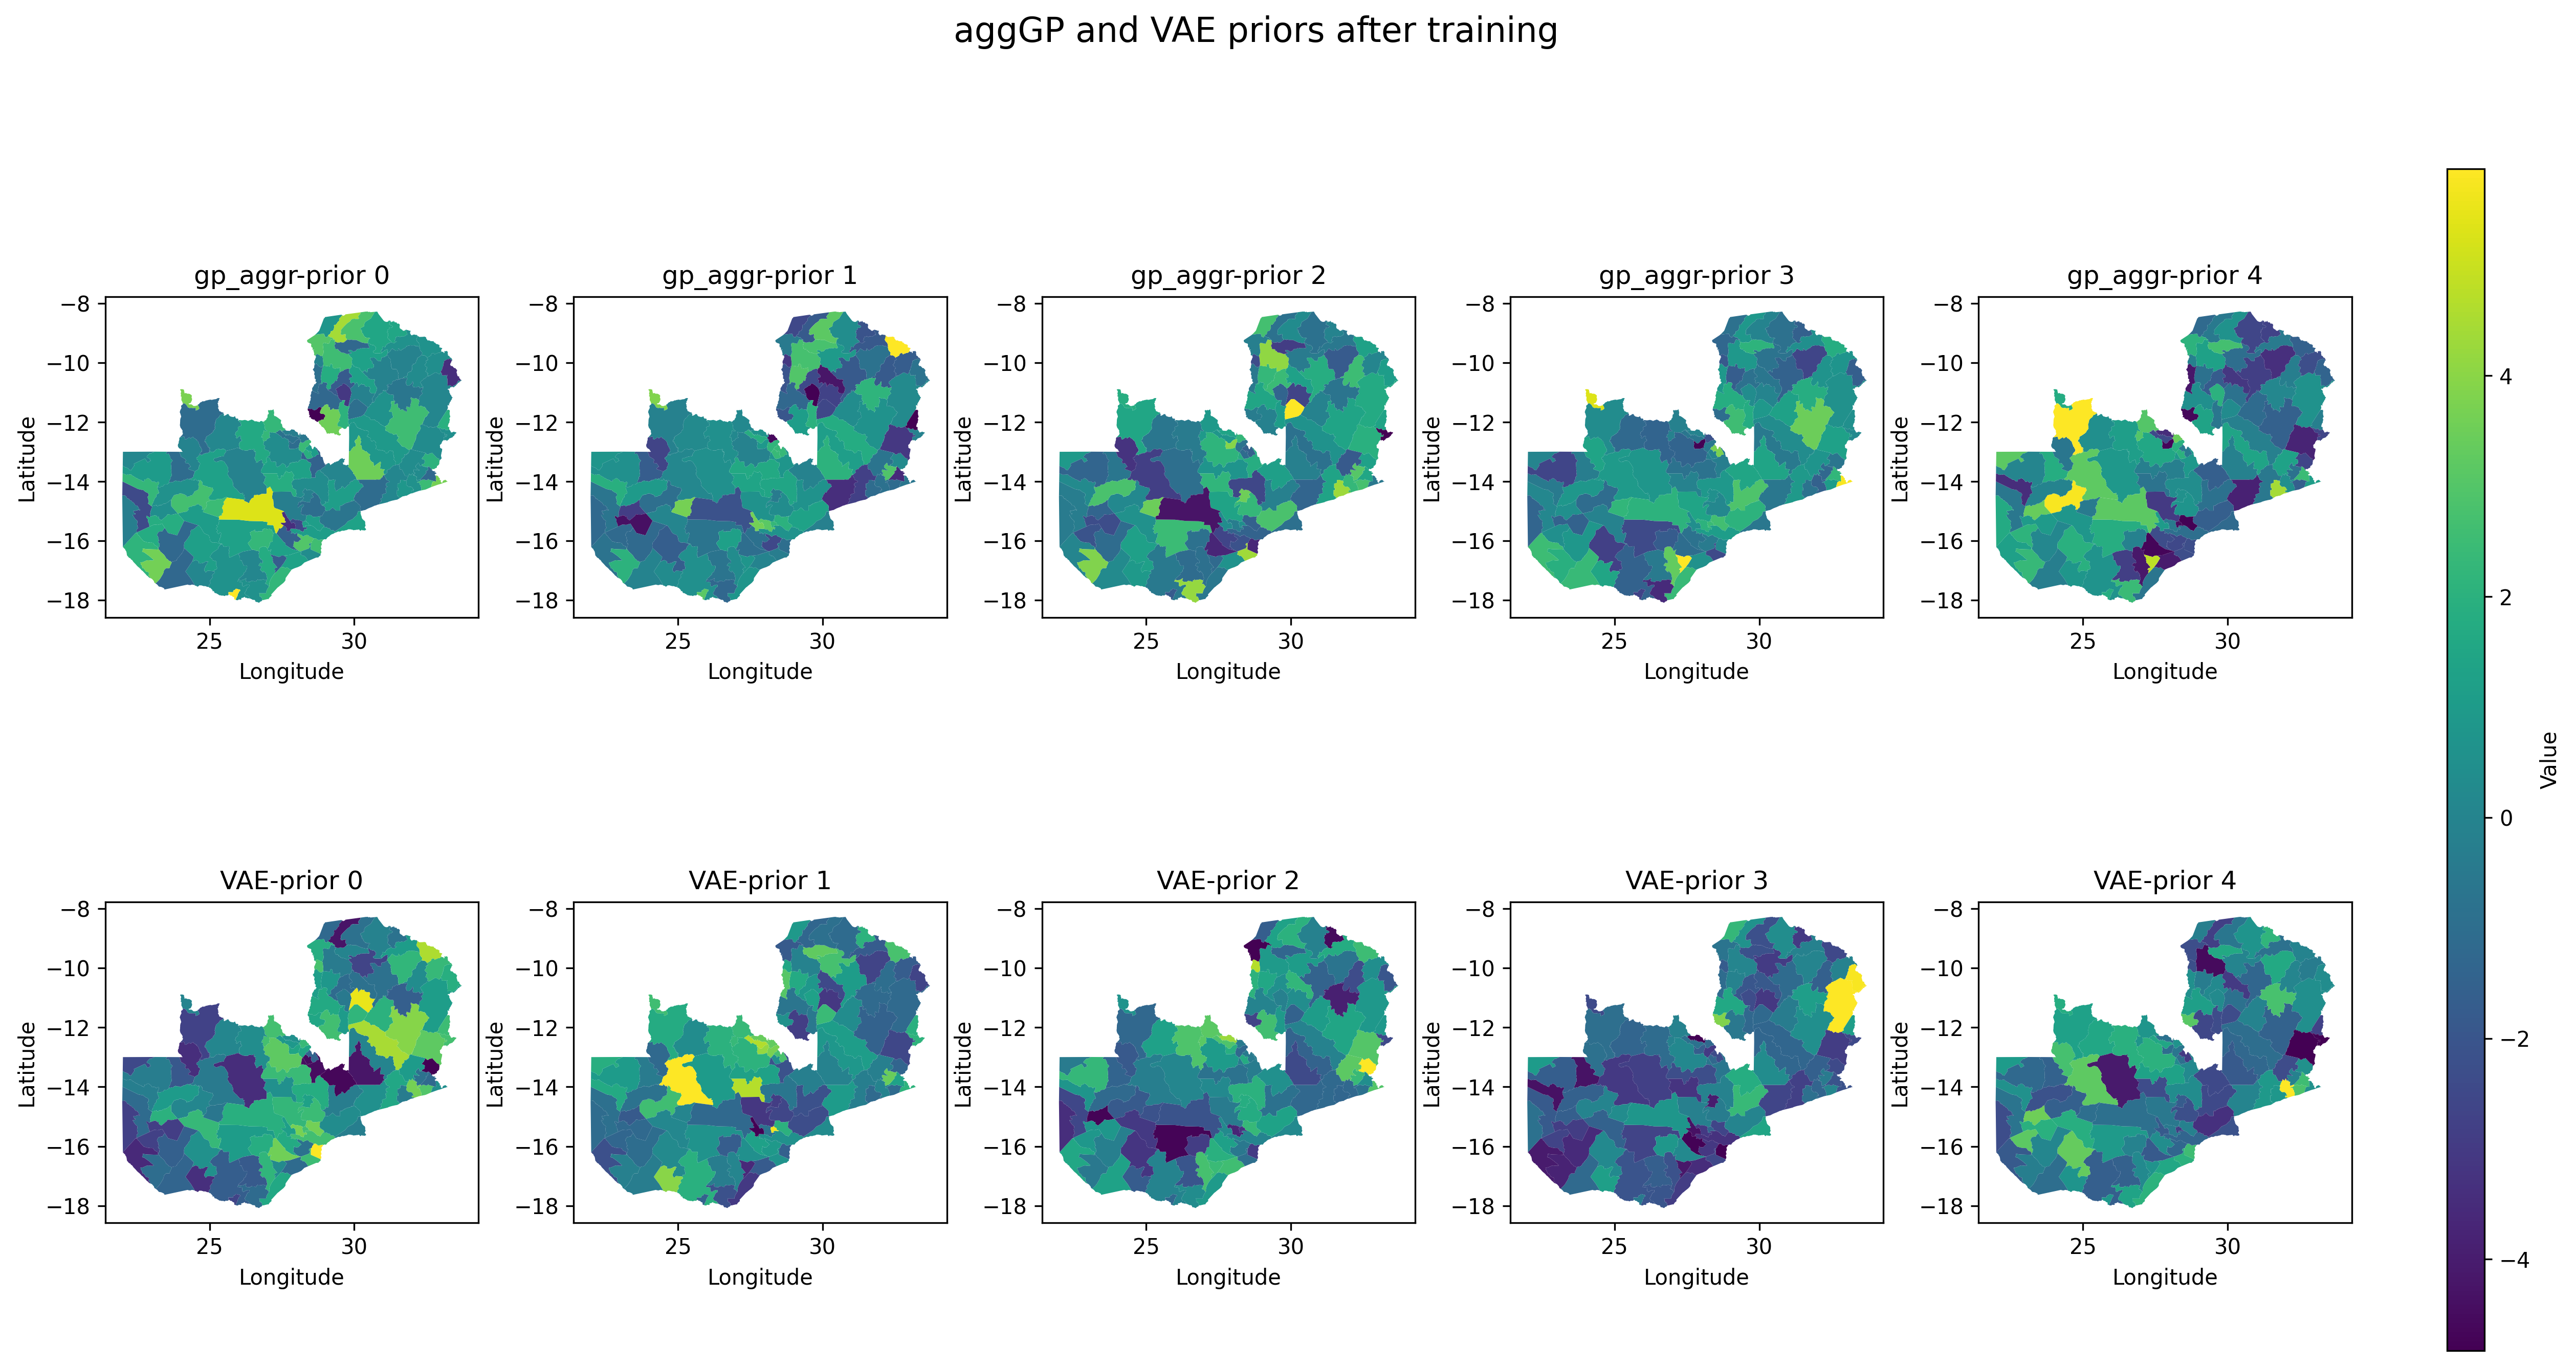

In [91]:
# Plot comparison of aggregated GP priors and their CVAE approximation after training

# Create a figure with a gridspec
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 6, width_ratios=[1, 1, 1, 1, 1, 0.1], height_ratios=[1, 1], wspace=0.3, hspace=0.05)  # Adjust wspace and hspace for more space between plots

axs = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(5)]

# Plot aggGP priors
for i in range(5):
    nm = 'gp_aggr_' + str(i)
    s_new_plot[nm] = agg_gp_draws[i, :]
    s_new_plot.plot(column=nm, ax=axs[i], legend=False)
    axs[i].set_xlabel('Longitude')
    axs[i].set_ylabel('Latitude')
    axs[i].set_title(f'gp_aggr-prior {i}')

# Plot VAE priors
for i in range(5):
    nm = 'vae_draw_' + str(i)
    s_new_plot[nm] = vae_draws[i][0]
    s_new_plot.plot(column=nm, ax=axs[5 + i], legend=False)
    axs[5 + i].set_xlabel('Longitude')
    axs[5 + i].set_ylabel('Latitude')
    axs[5 + i].set_title(f'VAE-prior {i}')

# Add an overall title
fig.suptitle('aggGP and VAE priors after training', fontsize=16)

# Create a shared colorbar
cbar_ax = fig.add_subplot(gs[:, 5])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=s_new_plot[nm].min(), vmax=s_new_plot[nm].max()))
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar_ax.set_ylabel('Value')


# Save the figure
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig('figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+model_specs+'_aggGP_VAE_priors_after_training.pdf')
plt.show()

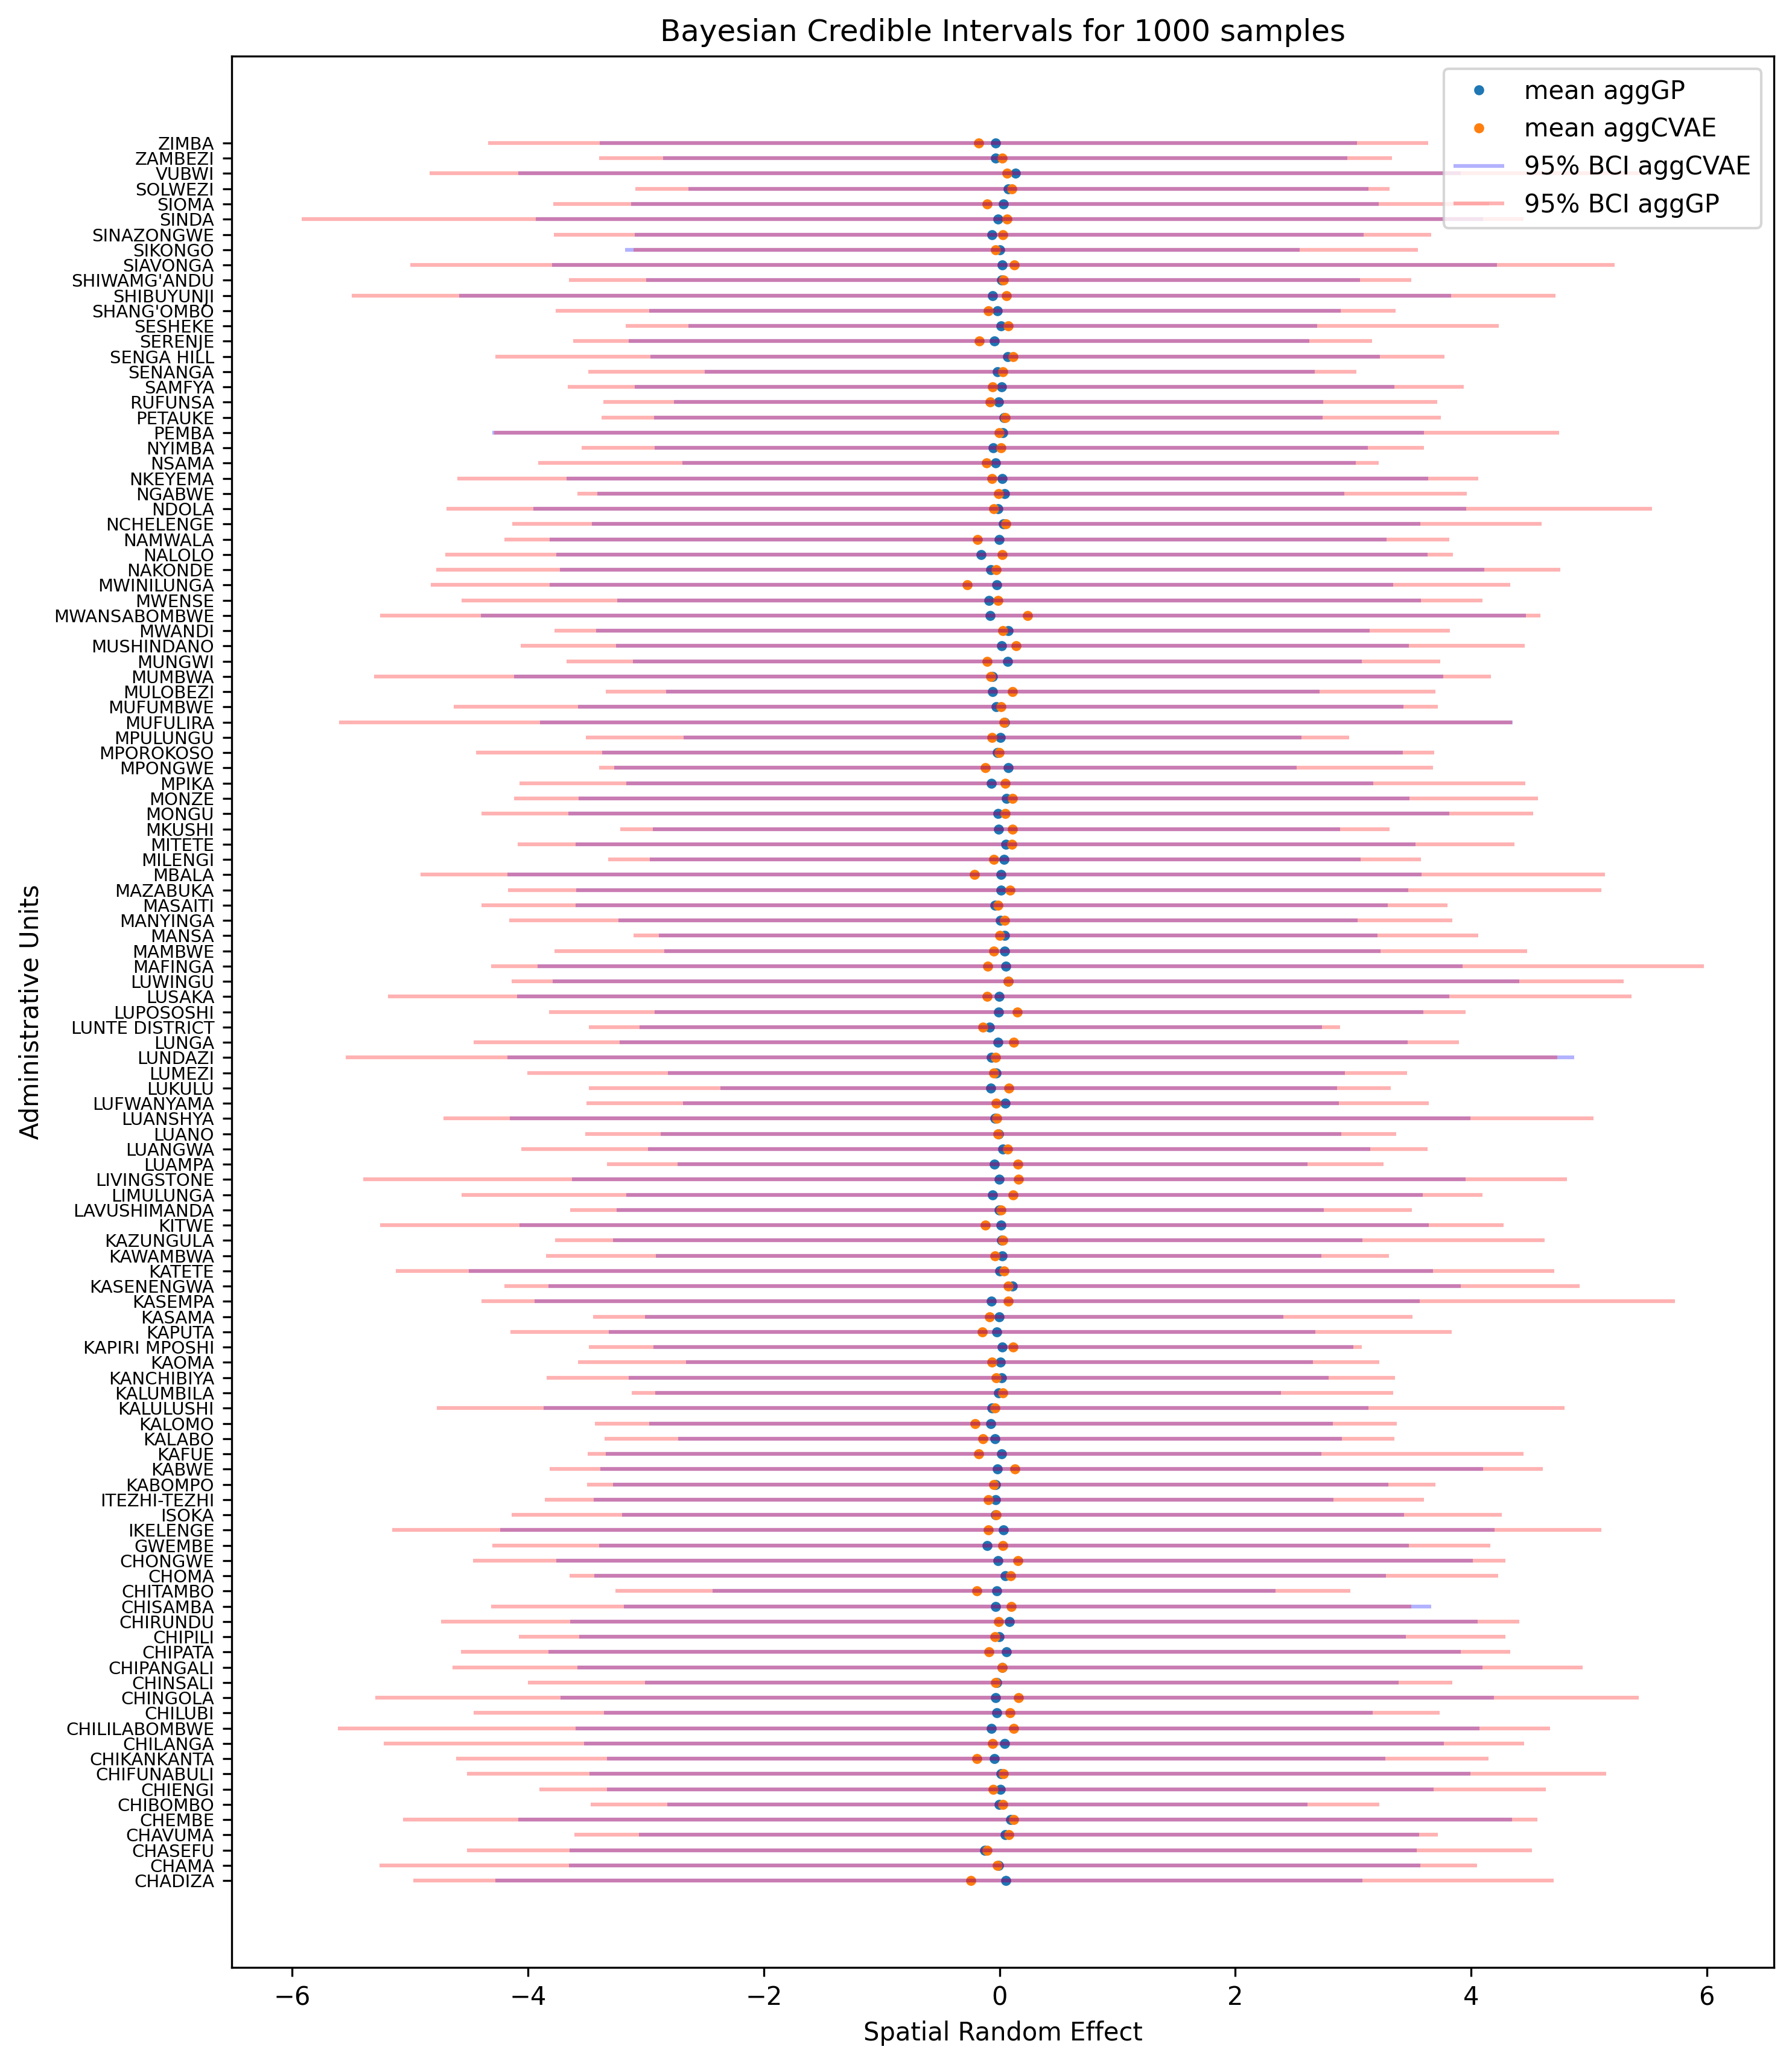

In [93]:
# Plot Bayesian Credible Intervals for aggregated GP priors and their CVAE approximation after training

mean_vae_draws = jnp.mean(vae_draws, axis=0)
hpdi_vae_draws = hpdi(vae_draws, 0.95)
mean_gp_aggr = jnp.mean(agg_gp_draws, axis=0)
hpdi_gp_aggr = hpdi(agg_gp_draws,  0.95)

x = np.arange(0, s.shape[0], 1)

# Sort values for plotting by x axis
idx = jnp.argsort(x)
x_axis = s['area']

mean_cvae = mean_vae_draws[1][idx]
mean_gp = mean_gp_aggr[idx]

hpdi_cvae = hpdi_vae_draws[:, :, idx]
hpdi_gp = hpdi_gp_aggr[:, idx]

# Calculate reasonable figure height based on the number of administrative units
fig_height = max(len(x_axis) * 0.1, 8)  # Adjust 0.4 as needed to fit the labels comfortably


# Plot with flipped axes
plt.figure(figsize=(10, fig_height))  # Increase the height of the figure
plt.plot(mean_gp, x_axis, ".", label="mean aggGP")
plt.plot(mean_cvae, x_axis, ".", label="mean aggCVAE") 
plt.hlines(x_axis, xmin=hpdi_cvae[0][0], xmax=hpdi_cvae[1][0], colors="blue", alpha=0.3, label="95% BCI aggCVAE")  # Flipped axes
plt.hlines(x_axis, xmin=hpdi_gp[0], xmax=hpdi_gp[1], colors="red", alpha=0.3, label="95% BCI aggGP")              # Flipped axes
plt.legend()
plt.xlabel('Spatial Random Effect')
plt.ylabel('Administrative Units')
plt.title(f'Bayesian Credible Intervals for {args["num_samples_posterior"]} samples')

# Adjust y-axis ticks and label spacing
plt.yticks(np.arange(len(x_axis)), x_axis, fontsize=7)  # Customize fontsize and spacing

# Save plot
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.tight_layout()
plt.savefig('figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+model_specs+'_BCI_intervals_priors_after_training.pdf')
plt.show()

## Prevalence model - CVAE

In this section, we define the HIV prevalence model AggCVAE, estimate its parameters using MCMC and analyse its predictions.

In [94]:
# AggCVAE HIV prevalence model, using CVAE-approximated GP priors

def prev_model_vae_aggr(args, y=None):

    n_obs = args['n_obs']
    x = args["x"]
    
    # hyperparameters
    ls = numpyro.sample("kernel_length", args['hyperprior_ls'])
    var = numpyro.sample("kernel_var", args['hyperprior_var'])

    
    # random effect
    decoder_params = args["decoder_params"]
    z_dim_cond, hidden_dim = decoder_params['Dense_0']['kernel'].shape
    z_dim = z_dim_cond - 2   # z_dim_cond includes both lengthscale and variance
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    z = z.reshape(1, z.shape[0])
    prior_cvae_sample =  build_prior_cvae(num_s, z_dim=args['z_dim'], hidden_dim=args['hidden_dim'])
    decoder_nn = prior_cvae_sample.apply({"params": {'decoder': decoder_params}}, z, var, ls, method='decode')
    vae_aggr = numpyro.deterministic("vae_aggr", decoder_nn)
    
    s = numpyro.sample("sigma", dist.HalfNormal(50))
    vae = numpyro.deterministic('vae', s * vae_aggr)

    # fixed effects
    b0 = numpyro.sample('b0', dist.Normal(0, 1))
    lp = b0 + vae
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp))

    numpyro.sample("obs", dist.BinomialLogits(total_count = n_obs, logits=lp), obs=y)

In [114]:
# Run MCMC inference

run_mcmc = True

if run_mcmc:

    rng_key, rng_key_predict = random.split(random.PRNGKey(6))

    # inference
    start = time.time()
    kernel = NUTS(prev_model_vae_aggr)
    mcmc_vae = MCMC(kernel, num_warmup=args['num_warmup'], num_samples=args['num_mcmc_samples'], num_chains=4)
    mcmc_vae.run(rng_key, args, y = jnp.array(s.y))
    t_elapsed = time.time() - start

    prev_samples = mcmc_vae.get_samples()
    mcmc_vae.print_summary(exclude_deterministic=False)

    print("\nMCMC elapsed time:", round(t_elapsed), "s")

    ss = numpyro.diagnostics.summary(mcmc_vae.get_samples(group_by_chain=True))
    r = np.mean(ss['vae_aggr']['n_eff'])
    print("Average ESS for all aggVAE effects : " + str(round(r)))

    ss = numpyro.diagnostics.summary(mcmc_vae.get_samples(group_by_chain=True))

    ess_new = np.mean(ss['vae_aggr']['n_eff'])
    r_hat_new = np.max(ss['vae_aggr']['r_hat'])

    print("Average ESS for all aggVAE-new effects : " + str(round(ess_new)))
    print("Max r_hat for all aggVAE-new effects : " + str(round(r_hat_new,2)))

    print("\nMCMC elapsed time:", round(t_elapsed), "s")
    ss = numpyro.diagnostics.summary(mcmc_vae.get_samples(group_by_chain=True))
    r = np.mean(ss['vae_aggr']['n_eff'])
    print("Average ESS for all VAE-CAR effects : " + str(round(r)))

/tmp/ipykernel_3209723/1887934252.py:10: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_vae = MCMC(kernel, num_warmup=args['num_warmup'], num_samples=args['num_mcmc_samples'], num_chains=4)
sample: 100%|█| 1200/1200 [00:26<00:00, 45.97it/s, 63 steps of size 9.98e-02. ac
sample: 100%|█| 1200/1200 [00:26<00:00, 45.49it/s, 63 steps of size 9.38e-02. ac
sample: 100%|█| 1200/1200 [00:24<00:00, 49.95it/s, 63 steps of size 1.06e-01. ac
sample: 100%|█| 1200/1200 [00:25<00:00, 47.29it/s, 63 steps of size 9.38e-02. ac



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0     -2.73      0.11     -2.74     -2.92     -2.57   1935.11      1.00
  kernel_length      0.31      0.18      0.28      0.05      0.57   7232.87      1.00
     kernel_var      0.08      0.03      0.08      0.04      0.12   7592.23      1.00
          sigma      0.41      0.05      0.40      0.33      0.49   2066.21      1.00
     theta[0,0]      0.05      0.02      0.04      0.02      0.08   4713.21      1.00
     theta[0,1]      0.06      0.01      0.06      0.04      0.08   5009.71      1.00
     theta[0,2]      0.03      0.01      0.03      0.01      0.05   5906.96      1.00
     theta[0,3]      0.06      0.02      0.06      0.03      0.10   6086.77      1.00
     theta[0,4]      0.02      0.01      0.02      0.00      0.04   4071.23      1.00
     theta[0,5]      0.05      0.01      0.04      0.03      0.06   5264.07      1.00
     theta[0,6]      0.04      0.01      0.04      0.

Average ESS for all aggVAE effects : 4642
Average ESS for all aggVAE-new effects : 4642
Max r_hat for all aggVAE-new effects : 1.0

MCMC elapsed time: 103 s
Average ESS for all VAE-CAR effects : 4642


In [115]:
# save MCMC
with open(f"MCMCs/ZMB2018_aggCVAE"+ model_specs + "mcmc", 'wb') as file:
   dill.dump(mcmc_vae, file)

In [116]:
# load MCMC
with open(f"MCMCs/ZMB2018_aggCVAE"+ model_specs + "mcmc", 'rb') as file:
   mcmc_vae = dill.load(file)

In [117]:
# Create LaTeX table for MCMC results

# Text content
content = (
    f"MCMC elapsed time: {round(t_elapsed)} s\n"
    f"Average ESS for all aggVAE effects: {round(r)}\n"
    f"Average ESS for all aggVAE-new effects: {round(ess_new)}\n"
    f"Max r_hat for all aggVAE-new effects: {round(r_hat_new, 2)}\n"
    f"MCMC elapsed time: {round(t_elapsed)} s\n"
    f"Average ESS for all VAE-CAR effects: {round(r)}\n"
)

# LaTeX table content
latex_content = r"""
\begin{table}[h!]
\centering
\begin{tabular}{|c|c|}
\hline
\textbf{Metric} & \textbf{Value} \\
\hline
MCMC elapsed time (s) & """ + f"{round(t_elapsed)}" + r""" \\
\hline
Average ESS for all aggVAE effects & """ + f"{round(r)}" + r""" \\
\hline
Average ESS for all aggVAE-new effects & """ + f"{round(ess_new)}" + r""" \\
\hline
Max r\_hat for all aggVAE-new effects & """ + f"{round(r_hat_new, 2)}" + r""" \\
\hline
MCMC elapsed time (s) & """ + f"{round(t_elapsed)}" + r""" \\
\hline
Average ESS for all VAE-CAR effects & """ + f"{round(r)}" + r""" \\
\hline
\end{tabular}
\caption{Summary of MCMC Results}
\label{table:mcmc_summary}
\end{table}
"""

# Save the text content to a pickle file
text_file_name = f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE' + model_specs + '_mcmc_summary_text.pkl'
with open(text_file_name, 'wb') as text_file:
    pickle.dump(content, text_file)

# Save the LaTeX content to a separate pickle file
latex_file_name = f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE' + model_specs + '_mcmc_summary_latex.tex'
with open(latex_file_name, 'w') as file:
    file.write(latex_content)

print(f"Text content has been saved to {text_file_name}")
print(f"LaTeX content has been saved to {latex_file_name}")

# To load the text content back from the pickle file (for verification)
with open(text_file_name, 'rb') as text_file:
    loaded_text_content = pickle.load(text_file)
    print("Loaded text content:")
    print(loaded_text_content)
    
# Load and verify the LaTeX table
with open(latex_file_name, 'r') as file:
    latex_data = file.read()
    print("\nLoaded from LaTeX file:")
    print(latex_data)

Text content has been saved to figures/ZMB2018_aggCVAE_admin2_mcmcsamp1000_h1024_z512_epochs100_lsGamma(3, 10)_varGamma(8, 100)/ZMB2018_aggCVAE_admin2_mcmcsamp1000_h1024_z512_epochs100_lsGamma(3, 10)_varGamma(8, 100)_mcmc_summary_text.pkl
LaTeX content has been saved to figures/ZMB2018_aggCVAE_admin2_mcmcsamp1000_h1024_z512_epochs100_lsGamma(3, 10)_varGamma(8, 100)/ZMB2018_aggCVAE_admin2_mcmcsamp1000_h1024_z512_epochs100_lsGamma(3, 10)_varGamma(8, 100)_mcmc_summary_latex.tex
Loaded text content:
MCMC elapsed time: 103 s
Average ESS for all aggVAE effects: 4642
Average ESS for all aggVAE-new effects: 4642
Max r_hat for all aggVAE-new effects: 1.0
MCMC elapsed time: 103 s
Average ESS for all VAE-CAR effects: 4642


Loaded from LaTeX file:

\begin{table}[h!]
\centering
\begin{tabular}{|c|c|}
\hline
\textbf{Metric} & \textbf{Value} \\
\hline
MCMC elapsed time (s) & 103 \\
\hline
Average ESS for all aggVAE effects & 4642 \\
\hline
Average ESS for all aggVAE-new effects & 4642 \\
\hline
Max 

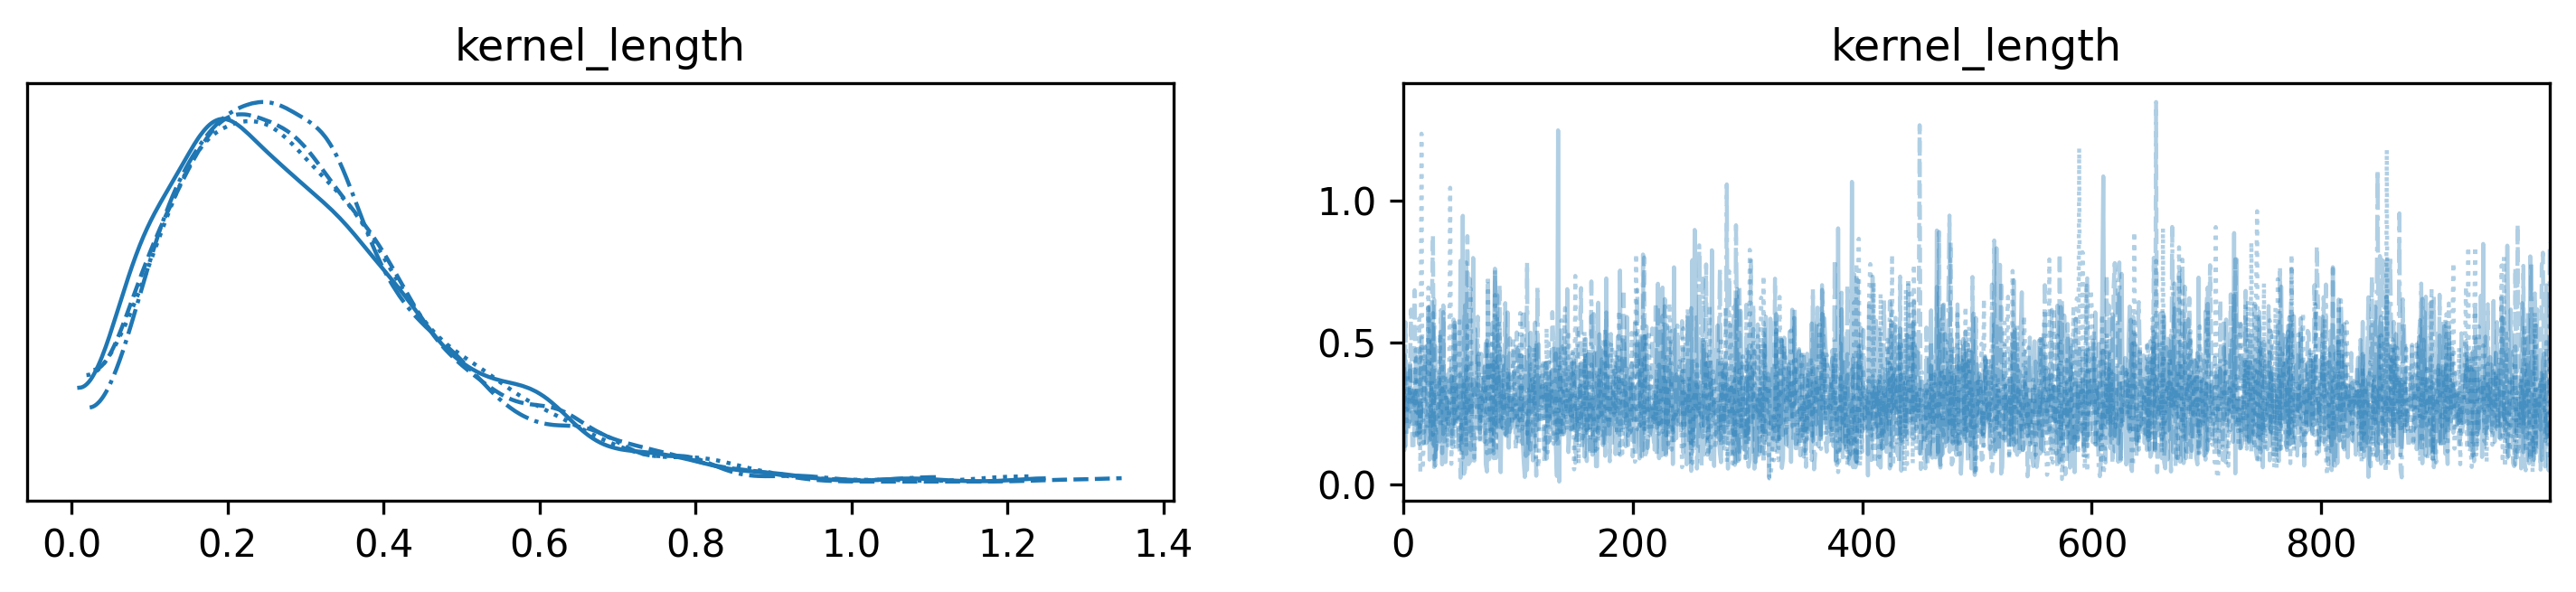

In [123]:
# Plot traceplots and posterior distributions of hyperparameters - lengthscale

import arviz as az
import matplotlib.pyplot as plt

# Assuming 'mcmc_vae' and 'model_specs' are defined elsewhere in your code
az_data = az.from_numpyro(mcmc_vae)

# Generate the trace plot
axes = az.plot_trace(az_data, var_names=('kernel_length'), filter_vars="like")

# Set x-axis and y-axis labels
for ax in axes.flatten():
    ax.set_xlabel('Sample Number')  # Customize as needed
    ax.set_ylabel('Density')        # Customize as needed

# Adjust the resolution settings
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Save the figure to a PDF file
plt.savefig(f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+ model_specs + '_ls_posterior_trace.pdf')

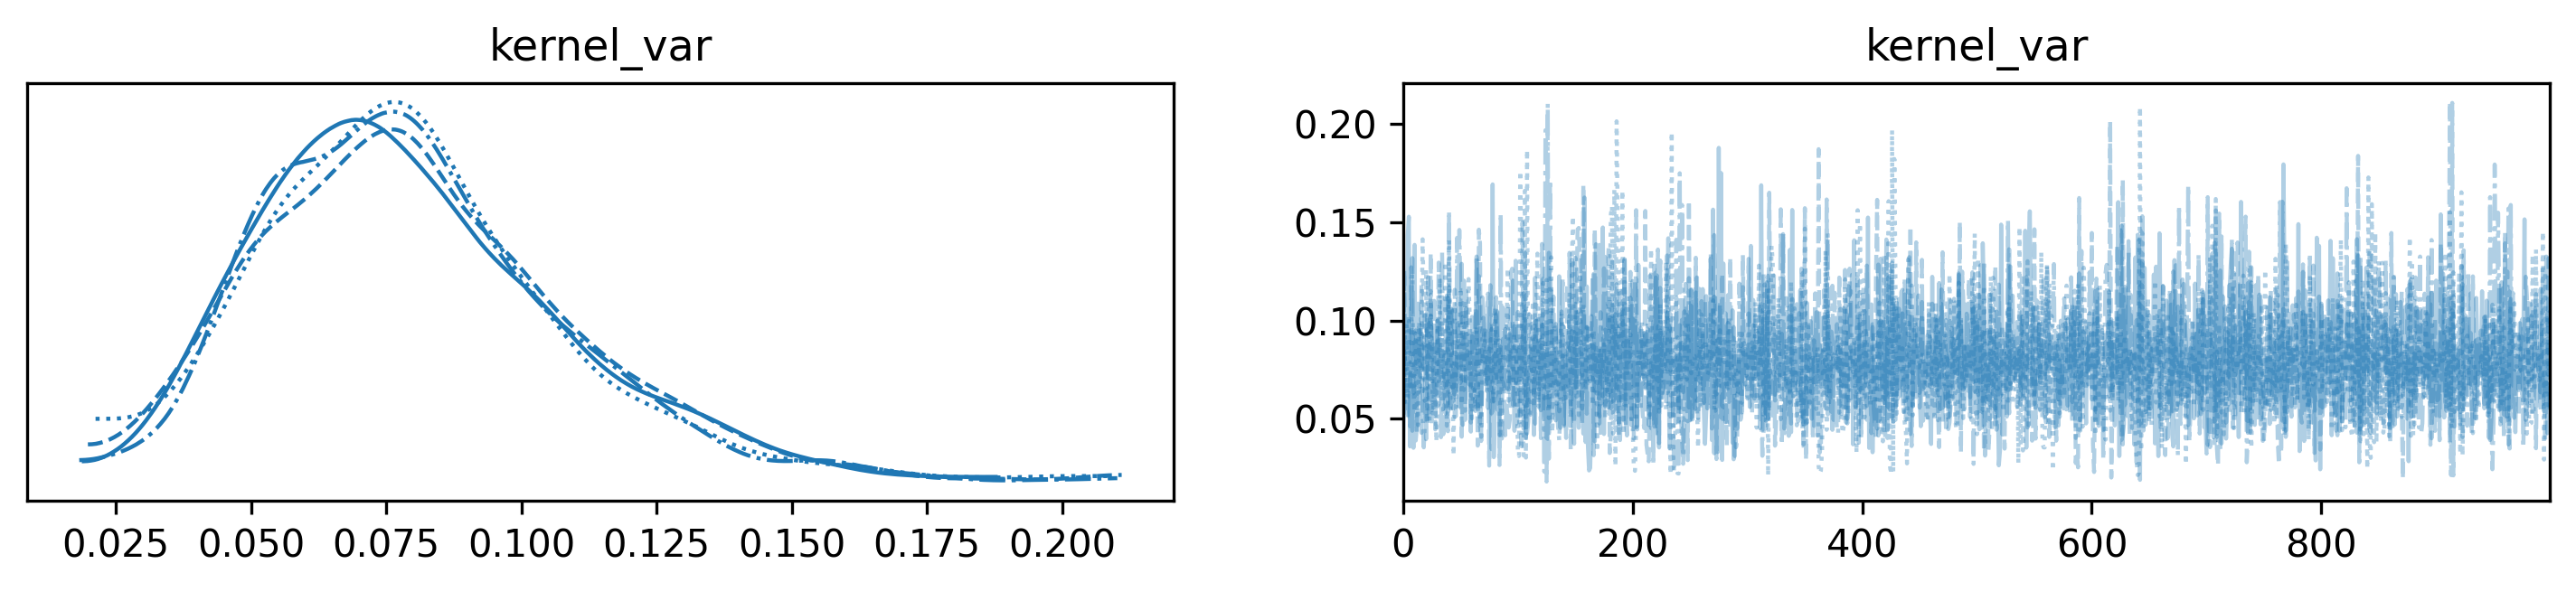

In [124]:
# Plot traceplots and posterior distributions of hyperparameters - variance

import arviz as az
import matplotlib.pyplot as plt

# Generate the trace plot
axes = az.plot_trace(az_data, var_names=('kernel_var'), filter_vars="like")

# Set x-axis and y-axis labels
for ax in axes.flatten():
    ax.set_xlabel('Sample Number')  # Customize as needed
    ax.set_ylabel('Density')        # Customize as needed

# Adjust the resolution settings
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Save the figure to a PDF file
plt.savefig(f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+ model_specs + '_var_posterior_trace.pdf')

In [125]:
# Obtain posterior samples of HIV prevalence for the AggCVAE model

prev_posterior_predictive_vae = Predictive(prev_model_vae_aggr, prev_samples)(random.PRNGKey(1), args)

theta_samps_vae_aggr = prev_posterior_predictive_vae['theta']
theta_mean_vae_aggr = theta_samps_vae_aggr.mean(axis=0)
# transpose
theta_mean_vae_aggr = theta_mean_vae_aggr.transpose()
bci_vae_aggr_025 = np.quantile(theta_samps_vae_aggr, 0.025, axis=0)
bci_vae_aggr_975 = np.quantile(theta_samps_vae_aggr, 0.975, axis=0)

s['theta_vae_aggr'] = theta_mean_vae_aggr

theta_observed = s['estimate']
theta_estimated_vae_aggr = s['theta_vae_aggr']

_max = np.max([theta_observed, theta_estimated_vae_aggr])
_min = np.min([theta_observed, theta_estimated_vae_aggr])

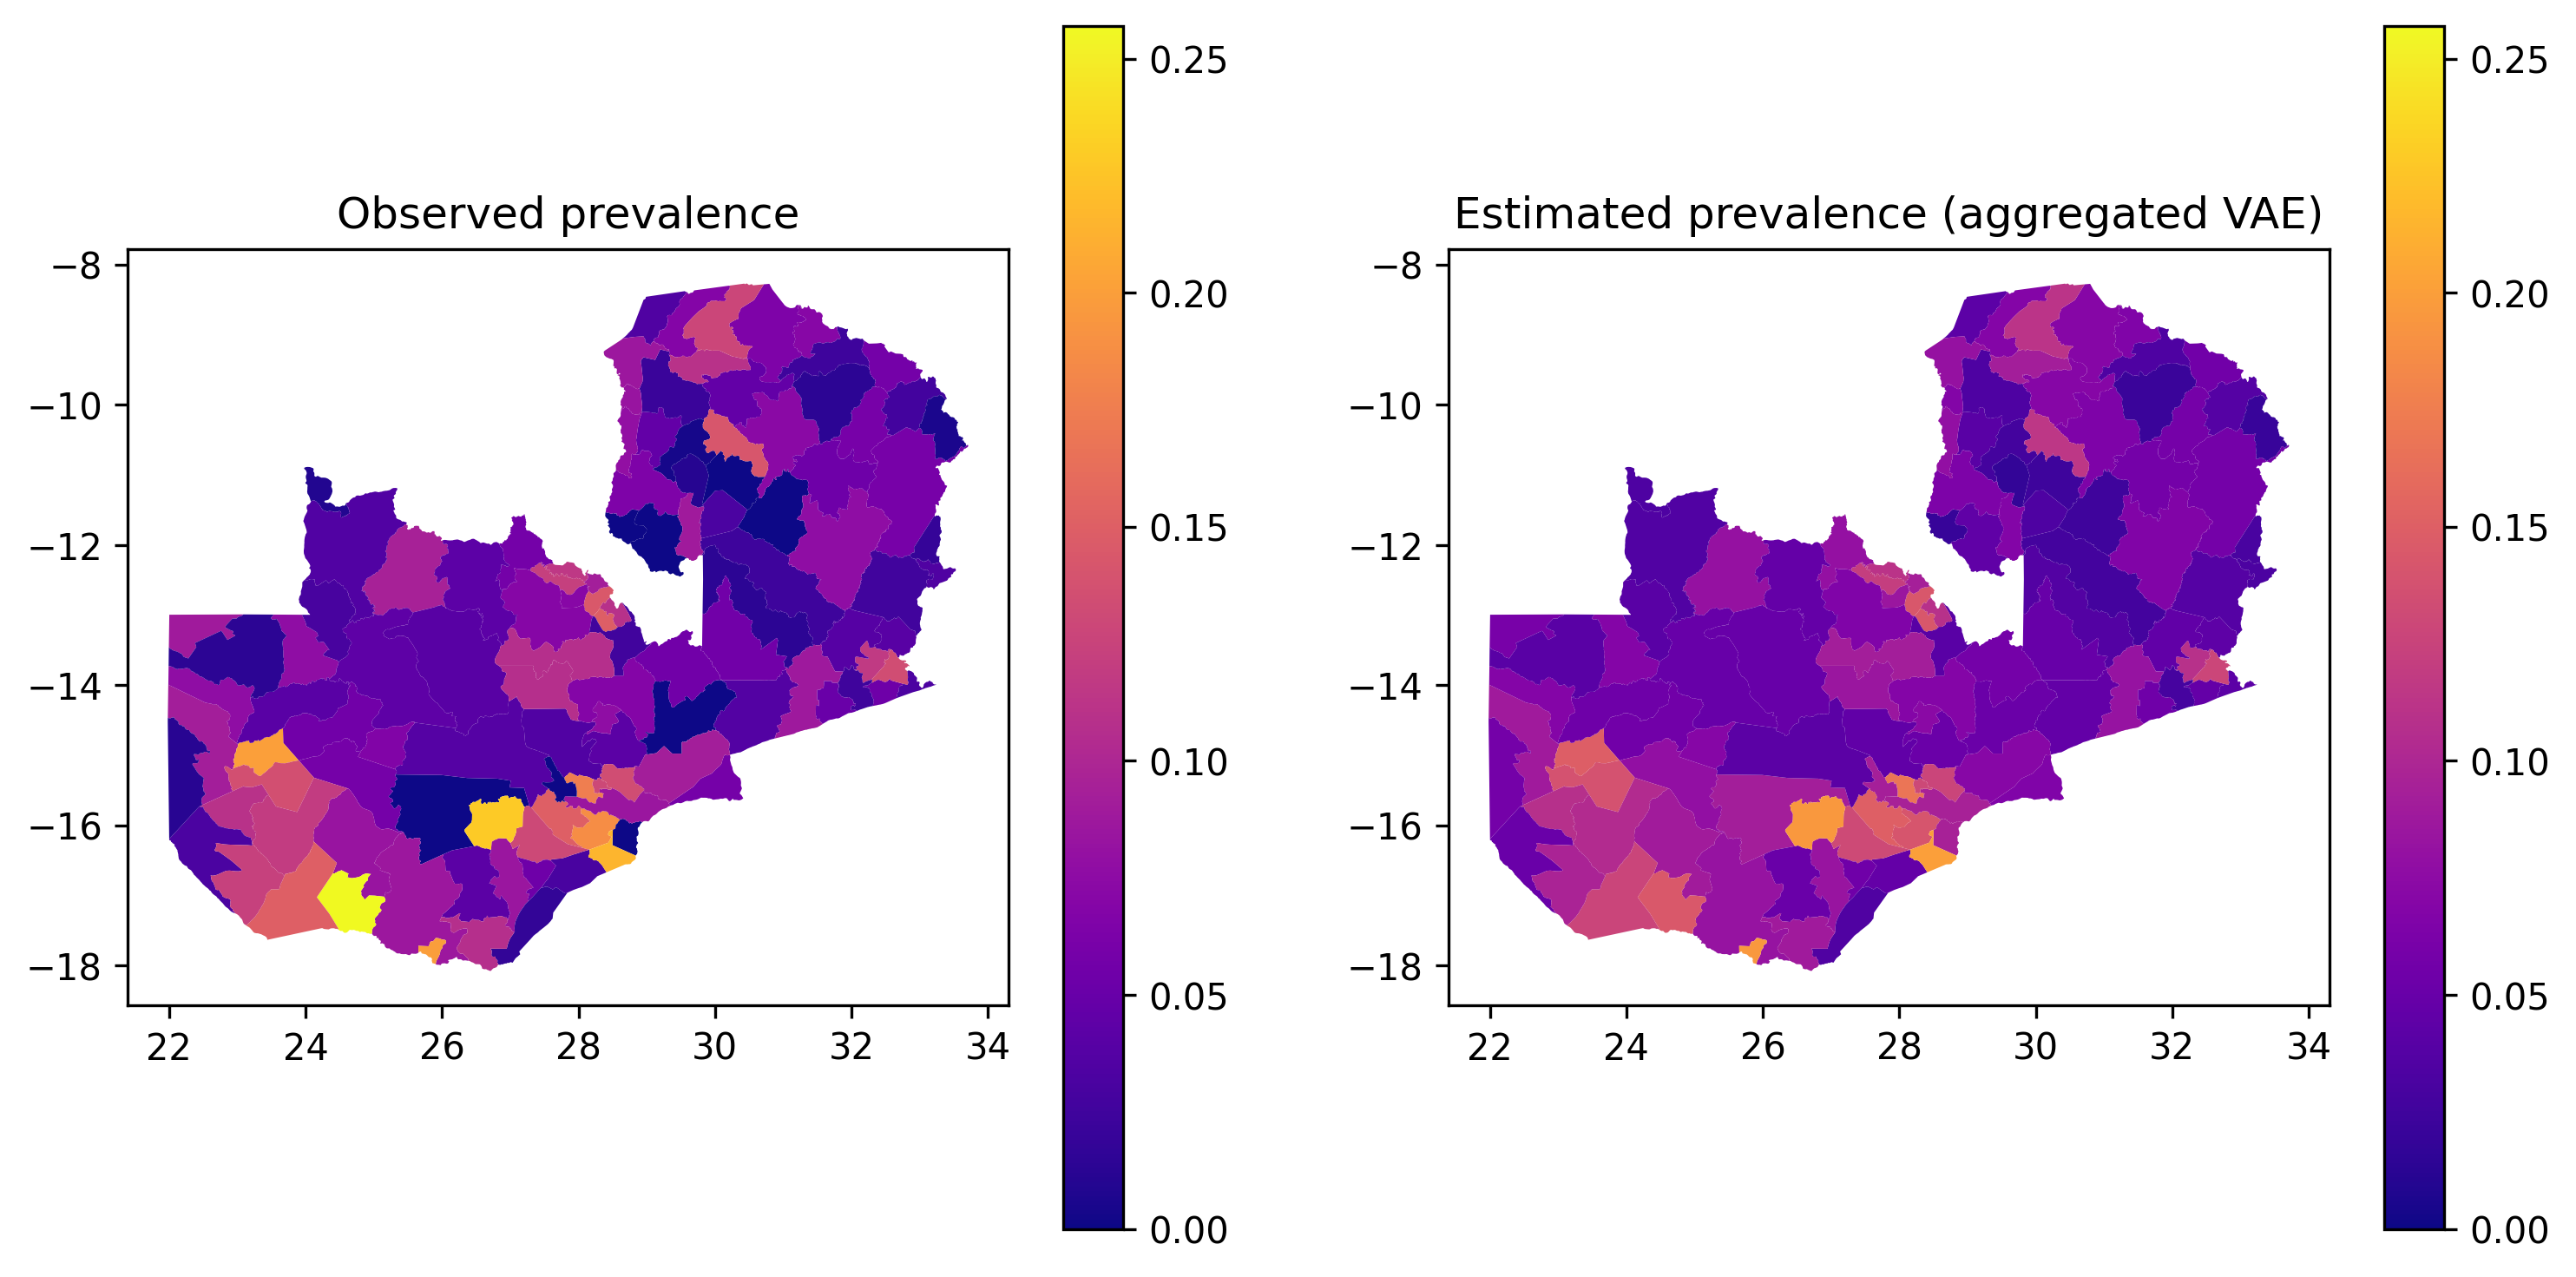

In [126]:
# Plot the spatial maps
fig, ax = plt.subplots(1, 2, figsize=(12,6))
s.plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s.plot(column="theta_vae_aggr", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)

ax[0].set_title('Observed prevalence')
ax[1].set_title('Estimated prevalence (aggregated VAE)')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig(f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+ model_specs + '_prev_results.pdf')

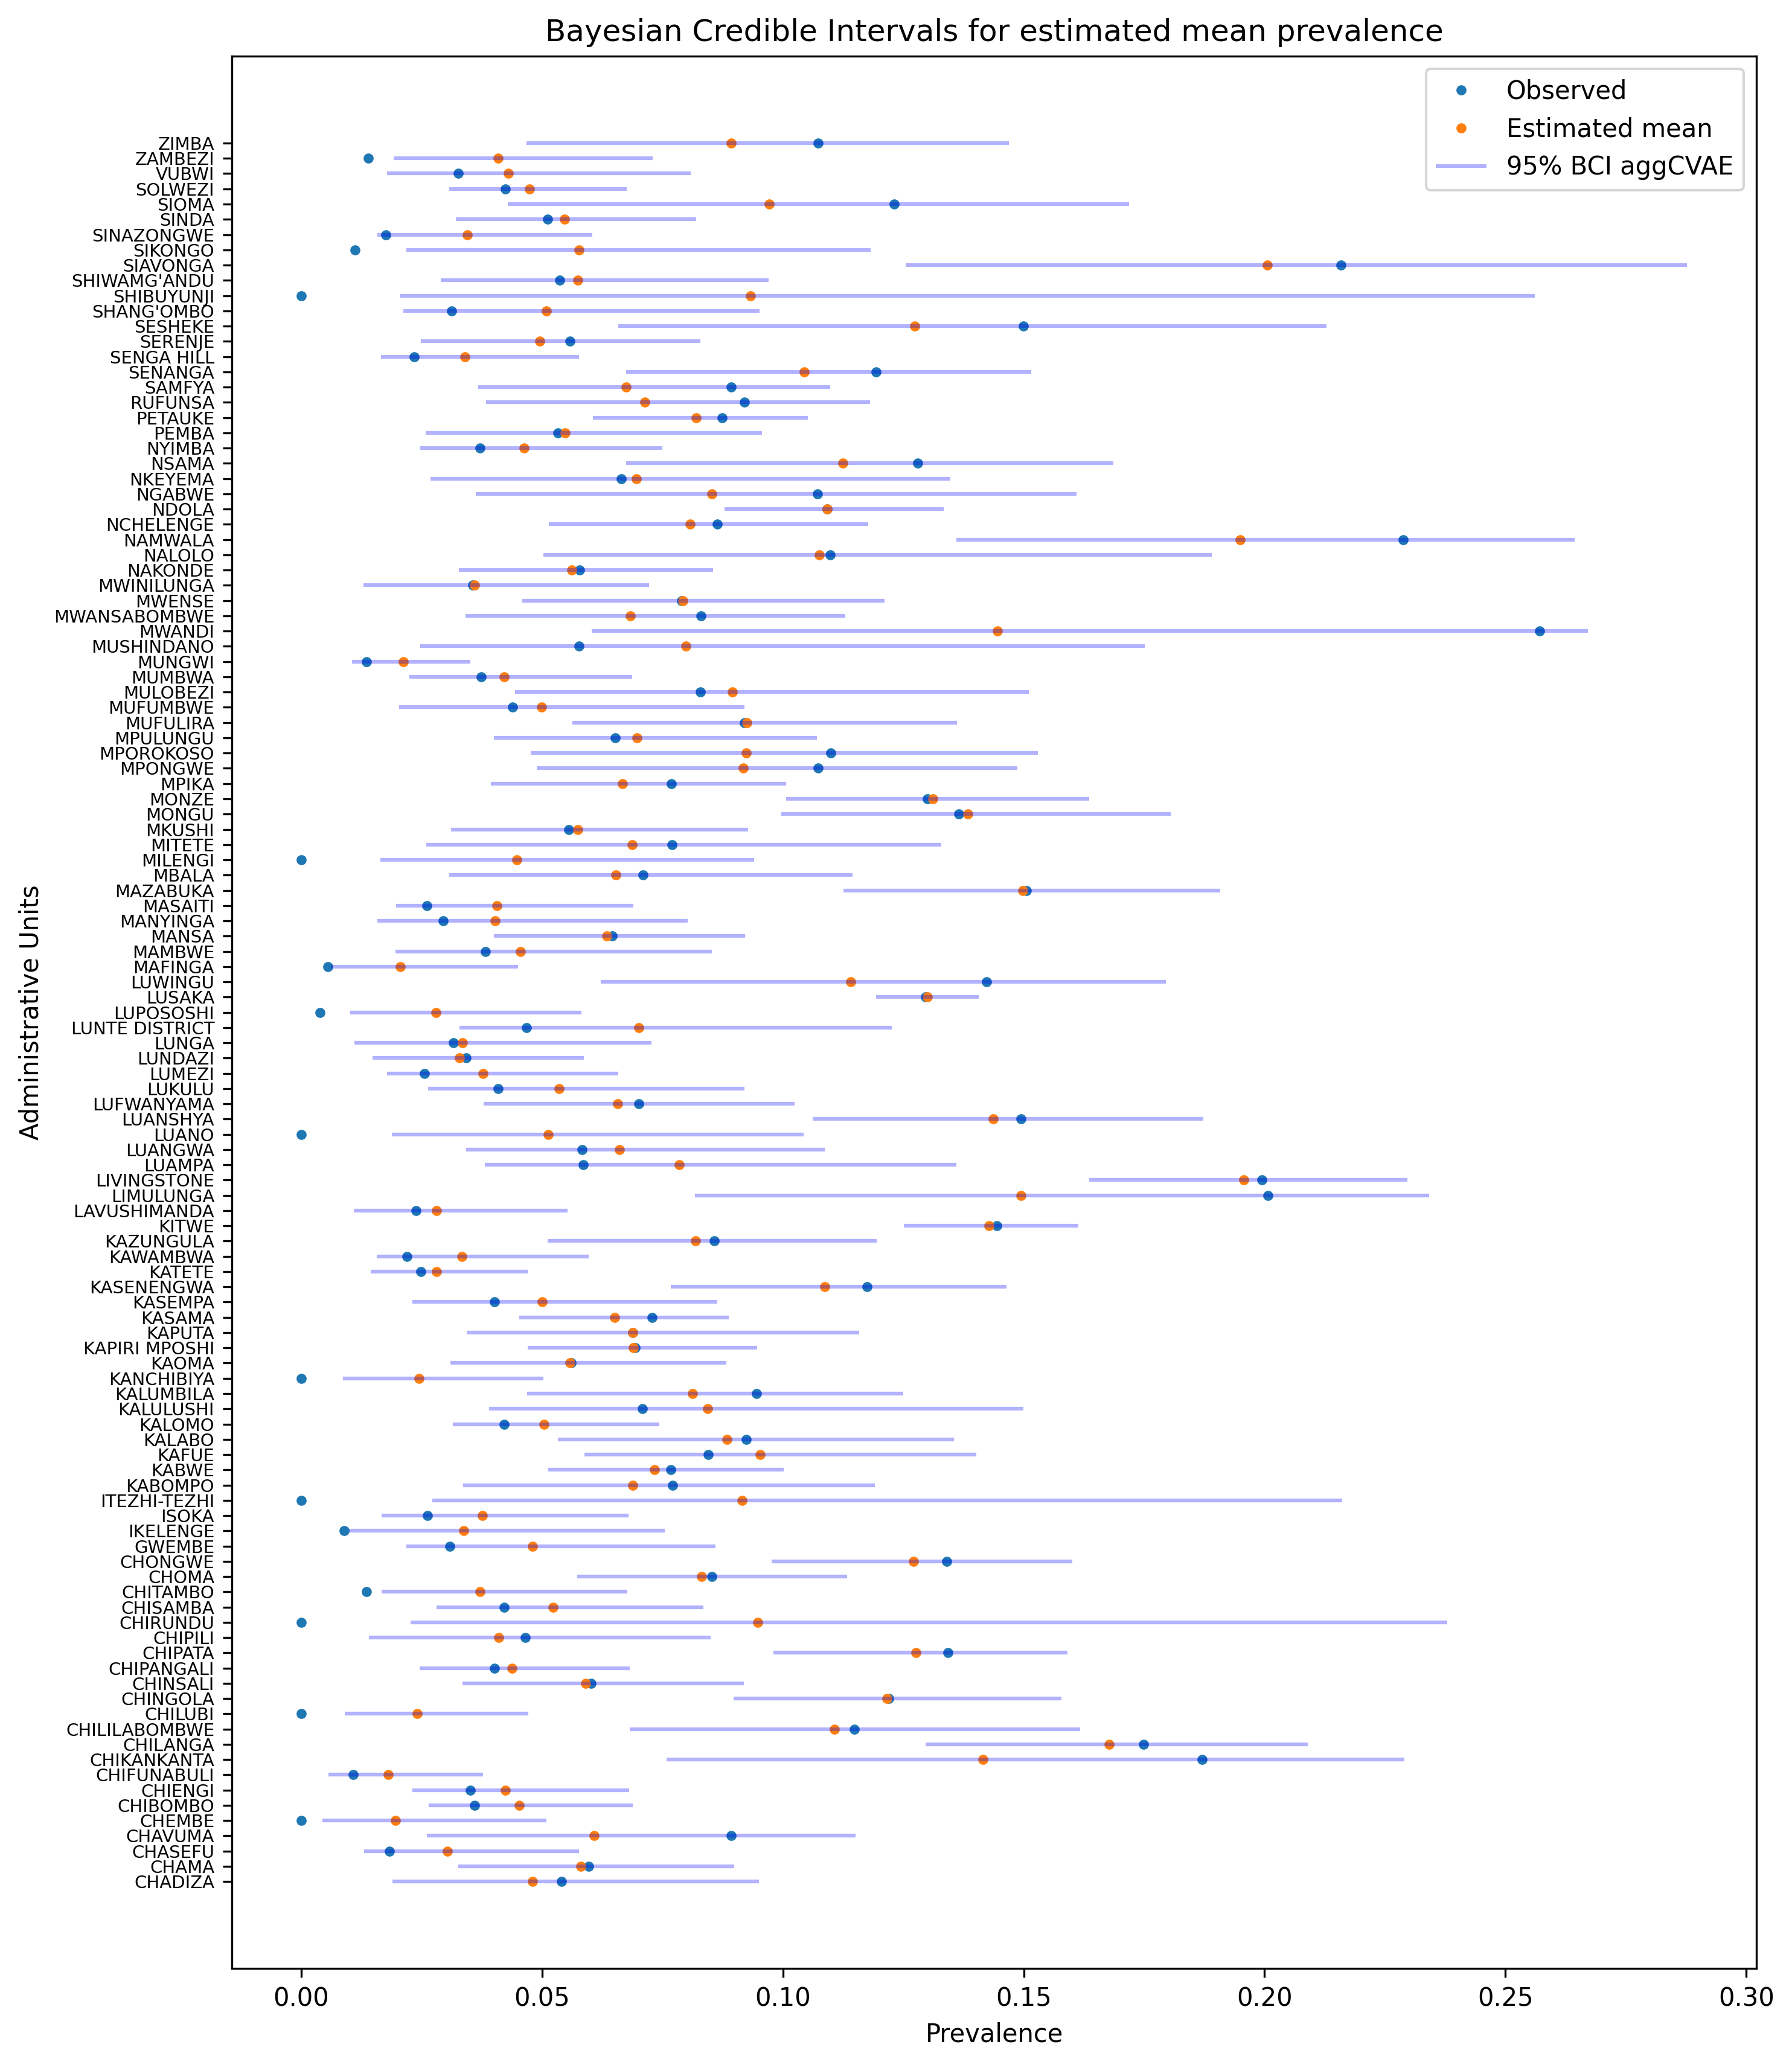

In [127]:
# plot the BCI intervals for the posterior distribution of HIV prevalence

x = np.arange(0, s.shape[0], 1)

# Sort values for plotting by x axis
idx = jnp.argsort(x)
x_axis = s['area']


# Calculate reasonable figure height based on the number of administrative units
fig_height = max(len(x_axis) * 0.1, 8)  # Adjust 0.4 as needed to fit the labels comfortably


# Plot with flipped axes
plt.figure(figsize=(10, fig_height))  # Increase the height of the figure
plt.plot(s["estimate"], x_axis, ".", label="Observed")
plt.plot(theta_mean_vae_aggr, x_axis, ".", label="Estimated mean") 
plt.hlines(x_axis, xmin=bci_vae_aggr_025, xmax=bci_vae_aggr_975, colors="blue", alpha=0.3, label="95% BCI aggCVAE")  # Flipped axes           # Flipped axes
plt.legend()
plt.xlabel('Prevalence')
plt.ylabel('Administrative Units')
plt.title(f'Bayesian Credible Intervals for estimated mean prevalence')

# Adjust y-axis ticks and label spacing
plt.yticks(np.arange(len(x_axis)), x_axis, fontsize=7)  # Customize fontsize and spacing

# Save plot
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.tight_layout()
plt.savefig('figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+model_specs+'_BCI_intervals_estimated_prev.pdf')
plt.show()

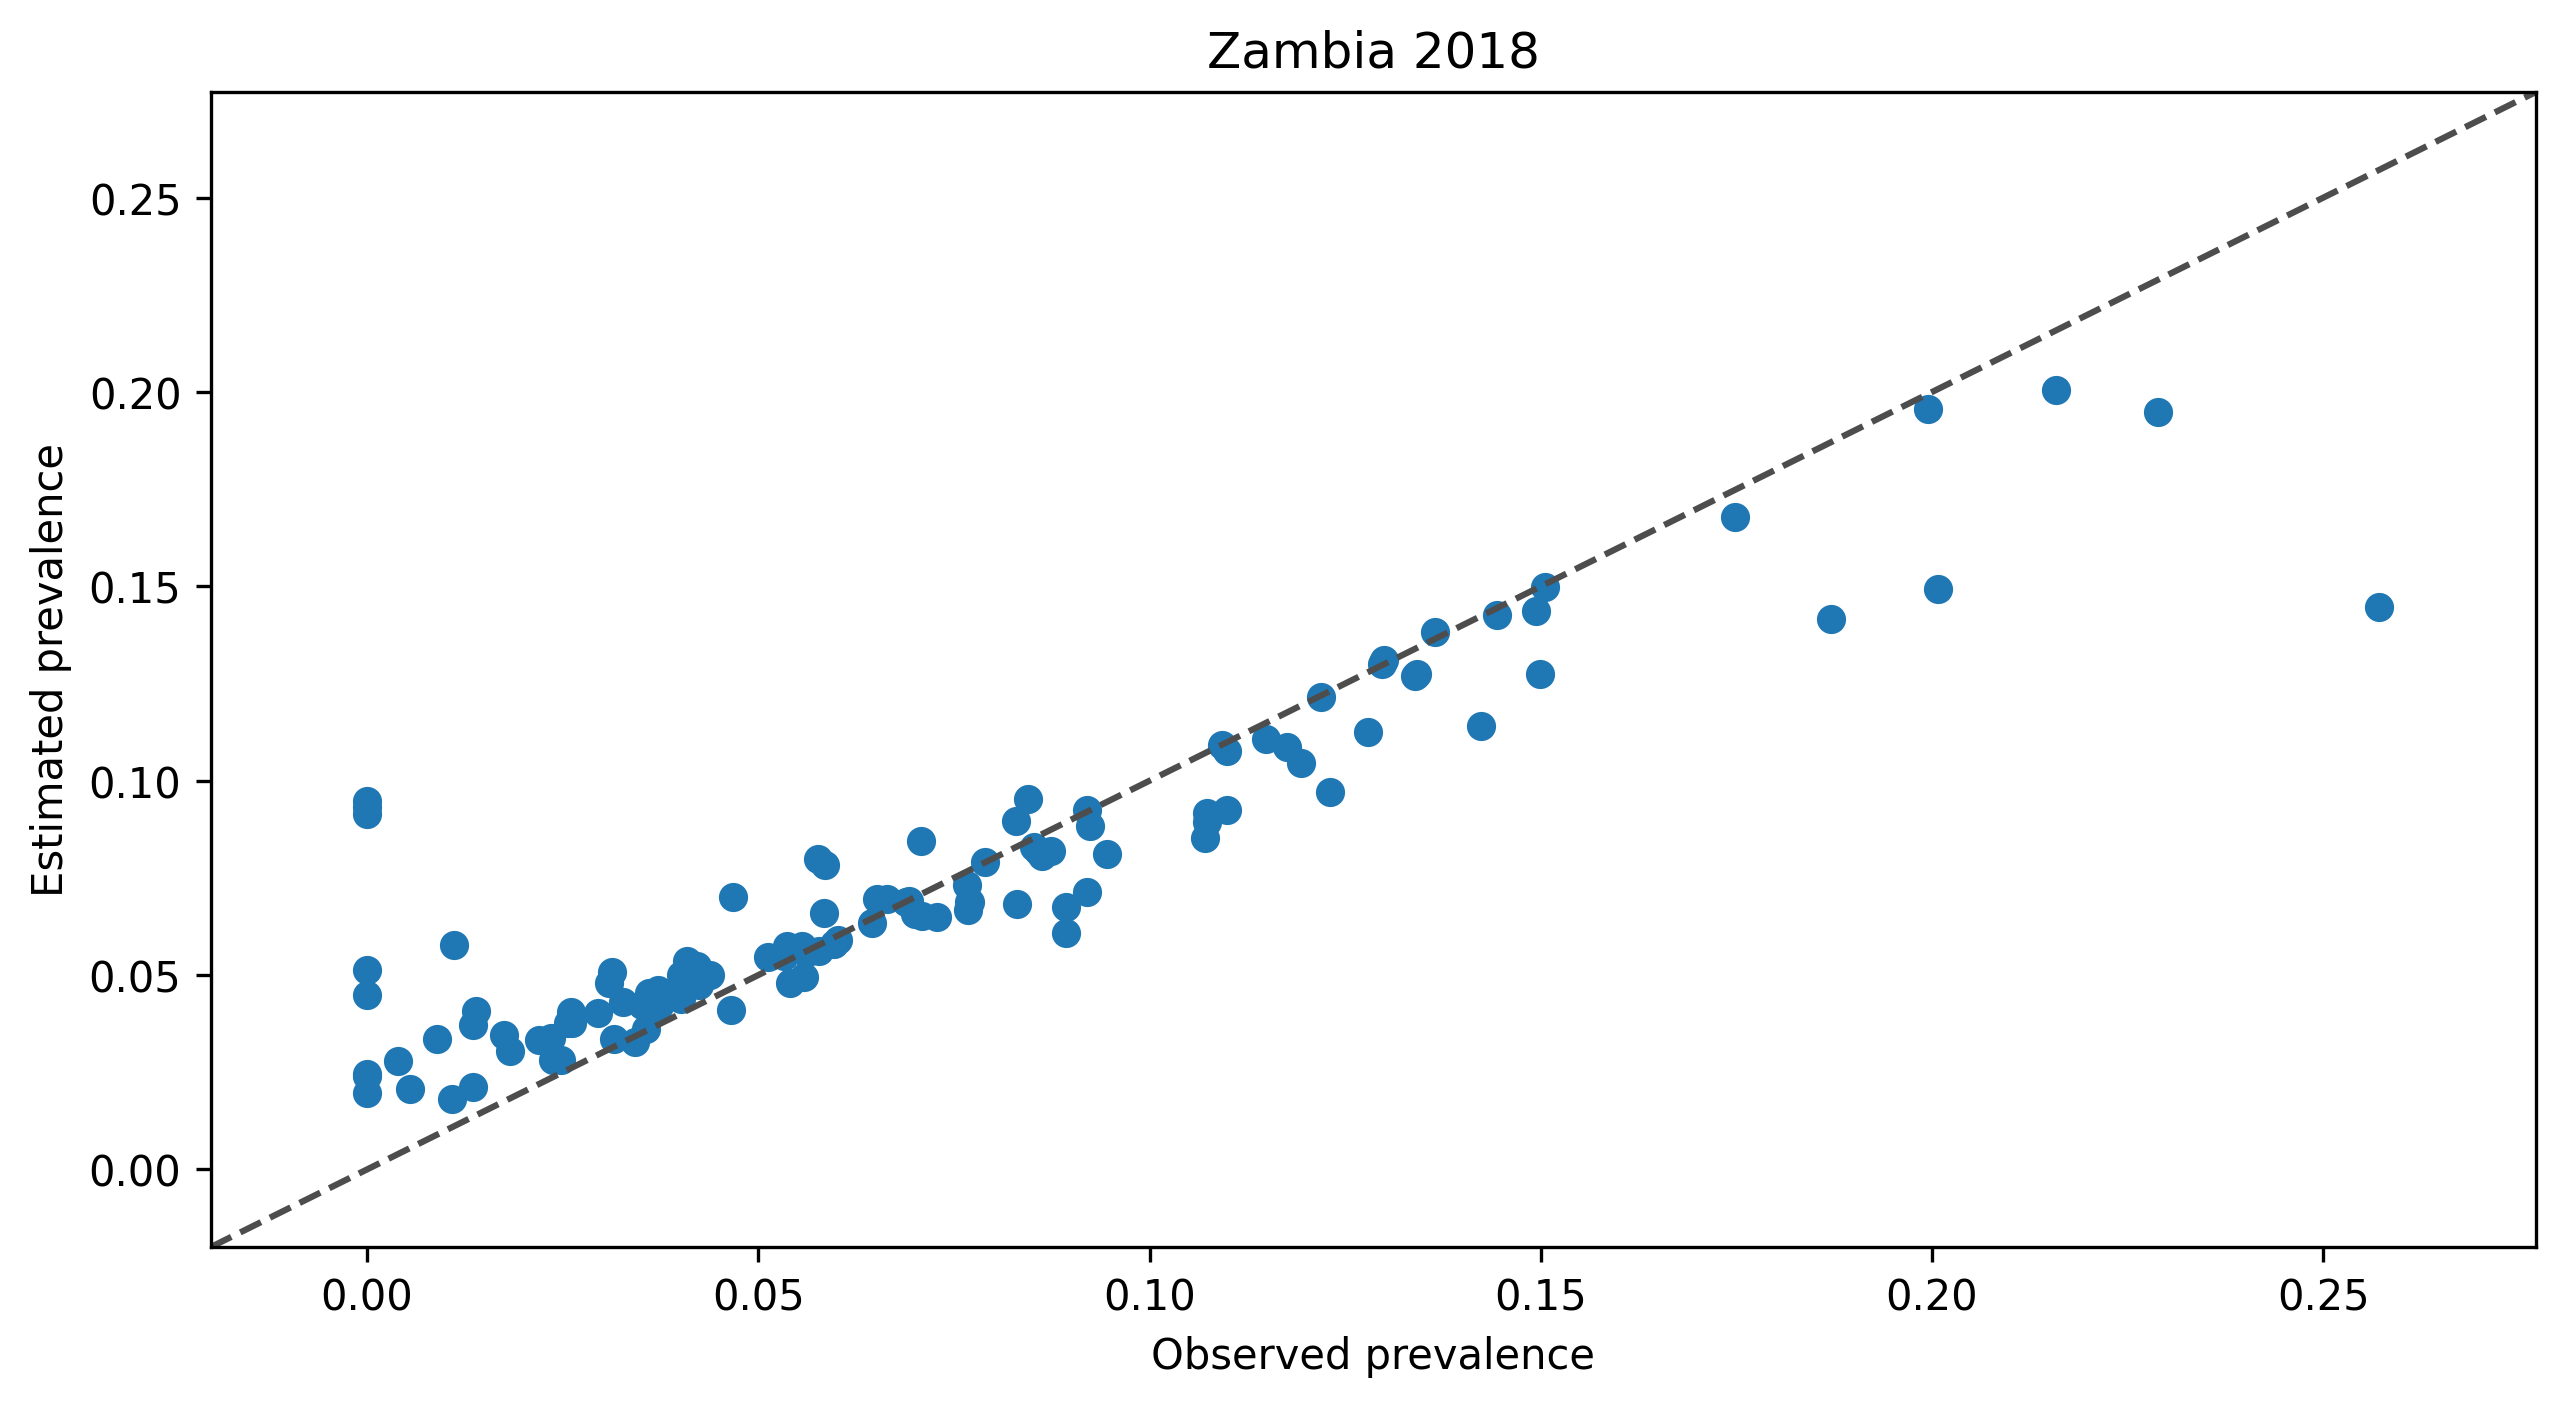

In [128]:
# Plot a scatterplot of Estimated Prevalence against Observed Prevalence
fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.scatter(s.estimate, s.theta_vae_aggr)
ax.set_ylim(_min-0.02, _max+0.02)
ax.set_xlim(_min-0.02, _max+0.02)
ax.axline((1, 1), slope=1, ls="--", c=".3")
ax.set_xlabel("Observed prevalence")
ax.set_ylabel("Estimated prevalence")
ax.set_title("Zambia 2018")


plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig(f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+ model_specs + '_prev_results_scatterplot.pdf')

In [129]:
# Calculate Performance Metrics for the AggCVAE predictions

# Example observations and predictions
observations = s.estimate
predictions = s.theta_vae_aggr

# Pearson correlation coefficient
pearson_corr, _ = pearsonr(observations, predictions)
print(f'Pearson correlation coefficient: {pearson_corr:.4f}')

# Spearman correlation coefficient
spearman_corr, _ = spearmanr(observations, predictions)
print(f'Spearman correlation coefficient: {spearman_corr:.4f}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(observations, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observations, predictions)
print(f'Mean Absolute Error (MAE): {mae:.4f}')

# Save results to a text file
with open(f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE' + model_specs + '_prev_metrics.txt', 'w') as file:
    file.write(f'Pearson correlation coefficient: {pearson_corr:.4f}\n')
    file.write(f'Spearman correlation coefficient: {spearman_corr:.4f}\n')
    file.write(f'Root Mean Squared Error (RMSE): {rmse:.4f}\n')
    file.write(f'Mean Absolute Error (MAE): {mae:.4f}\n')

# Generate LaTeX table
latex_table = f"""
\\documentclass{{article}}
\\usepackage{{booktabs}}

\\begin{{document}}

\\begin{{table}}[h!]
\\centering
\\begin{{tabular}}{{ll}}
\\toprule
Metric & Value \\\\
\\midrule
Pearson correlation coefficient & {pearson_corr:.4f} \\\\
Spearman correlation coefficient & {spearman_corr:.4f} \\\\
Root Mean Squared Error (RMSE) & {rmse:.4f} \\\\
Mean Absolute Error (MAE) & {mae:.4f} \\\\
\\bottomrule
\\end{{tabular}}
\\caption{{Performance Metrics}}
\\label{{tab:metrics}}
\\end{{table}}

\\end{{document}}
"""

latex_file = f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE' + model_specs + '_latex_metrics.tex'
# Save LaTeX table to a .tex file
with open(latex_file, 'w') as file:
    file.write(latex_table)

    
# Save metrics to a pickle file
pickle_file = f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE' + model_specs + '_prev_metrics.pkl'
metrics = {
    'pearson_corr': pearson_corr,
    'spearman_corr': spearman_corr,
    'rmse': rmse,
    'mae': mae
}
with open(pickle_file, 'wb') as file:
    pickle.dump(metrics, file)

# Load and verify the LaTeX table
with open(latex_file, 'r') as file:
    latex_data = file.read()
    print("\nLoaded from LaTeX file:")
    print(latex_data)

# Load and verify the pickle file results
with open(pickle_file, 'rb') as file:
    loaded_metrics = pickle.load(file)
    print("\nLoaded from pickle file:")
    print(loaded_metrics)

# Check if loaded metrics match the original metrics
assert np.isclose(loaded_metrics['pearson_corr'], pearson_corr), "Pearson correlation coefficient does not match."
assert np.isclose(loaded_metrics['spearman_corr'], spearman_corr), "Spearman correlation coefficient does not match."
assert np.isclose(loaded_metrics['rmse'], rmse), "RMSE does not match."
assert np.isclose(loaded_metrics['mae'], mae), "MAE does not match."

print("All metrics loaded correctly from the pickle file.")


Pearson correlation coefficient: 0.9099
Spearman correlation coefficient: 0.8739
Root Mean Squared Error (RMSE): 0.0242
Mean Absolute Error (MAE): 0.0146

Loaded from LaTeX file:

\documentclass{article}
\usepackage{booktabs}

\begin{document}

\begin{table}[h!]
\centering
\begin{tabular}{ll}
\toprule
Metric & Value \\
\midrule
Pearson correlation coefficient & 0.9099 \\
Spearman correlation coefficient & 0.8739 \\
Root Mean Squared Error (RMSE) & 0.0242 \\
Mean Absolute Error (MAE) & 0.0146 \\
\bottomrule
\end{tabular}
\caption{Performance Metrics}
\label{tab:metrics}
\end{table}

\end{document}


Loaded from pickle file:
{'pearson_corr': 0.9099319594198875, 'spearman_corr': 0.8738684822760248, 'rmse': 0.024236560542342706, 'mae': 0.01457127980380512}
All metrics loaded correctly from the pickle file.
